# Part A

In [1]:
from pathlib import Path
Path.cwd()

PosixPath('/home/nakyung/projects/vitaldb_ecg_arrhythmia/notebooks')

In [2]:
import os
os.chdir("..")

In [ ]:
# 0. 기본 세팅
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 1) 경로 설정 (네 환경에 맞게 수정)
CASES_PATH = "data/raw/cases.csv"  # 실제 위치로 바꿔줘

# 2) 데이터 로드
df_cases = pd.read_csv(CASES_PATH)
print(df_cases.shape)
df_cases.head()

(6388, 74)


,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_sao2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,0,0,77.0,M,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Left radial,NaN,NaN,NaN,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,0,0,54.0,M,167.3,54.8,19.6,2.0,0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,0,0,62.0,M,169.1,69.7,24.4,1.0,0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,0,0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,1,0,74.0,M,160.6,53.0,20.5,2.0,0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,1,0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,NaN,Right radial,NaN,NaN,NaN,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,13,0,66.0,M,171.0,59.7,20.4,3.0,1,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,1,0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Right radial,NaN,Right IJV,NaN,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100


## 1. 사용할 컬럼 선택 + 시간 컬럼 처리 + duration 생성

In [4]:
# 1-1. 사용할 컬럼 선택
cols_keep = [
    "caseid", "subjectid",
    "casestart", "caseend",
    "anestart", "aneend",
    "opstart", "opend",
    "icu_days", "death_inhosp",
    "age", "sex", "height", "weight", "bmi",
    "asa", "emop",
    "department", "optype", "opname",
    "preop_htn", "preop_dm",
    "preop_ecg",   # 나중에 predictor로 쓸 수도 있으니 일단 보존
    "preop_hb", "preop_plt", "preop_pt", "preop_aptt",
    "preop_na", "preop_k", "preop_gluc",
]

cols_keep = [c for c in cols_keep if c in df_cases.columns]
df = df_cases[cols_keep].copy()
print("선택한 컬럼 수:", len(cols_keep))
df.head()


선택한 컬럼 수: 30


,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,opname,preop_htn,preop_dm,preop_ecg,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc
0,1,5955,0,11542,-552,10848.0,1668,10368,0,0,77.0,M,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Low anterior resection,1,0,Normal Sinus Rhythm,14.1,189.0,94.0,33.2,141.0,3.1,134.0
1,2,2487,0,15741,-1039,14921.0,1721,14621,0,0,54.0,M,167.3,54.8,19.6,2.0,0,General surgery,Stomach,Subtotal gastrectomy,0,0,Normal Sinus Rhythm,10.2,251.0,110.0,31.9,143.0,4.7,88.0
2,3,2861,0,4394,-590,4210.0,1090,3010,0,0,62.0,M,169.1,69.7,24.4,1.0,0,General surgery,Biliary/Pancreas,Cholecystectomy,0,0,Normal Sinus Rhythm,14.2,373.0,103.0,30.3,144.0,4.9,87.0
3,4,1903,0,20990,-778,20222.0,2522,17822,1,0,74.0,M,160.6,53.0,20.5,2.0,0,General surgery,Stomach,Distal gastrectomy,1,0,Normal Sinus Rhythm,14.4,275.0,103.0,34.5,141.0,4.2,108.0
4,5,4416,0,21531,-1009,22391.0,2591,20291,13,0,66.0,M,171.0,59.7,20.4,3.0,1,General surgery,Vascular,Aneurysmal repair,1,0,Left anterior fascicular block,10.1,67.0,73.0,36.5,146.0,4.4,126.0


In [5]:
# 1-2. 시간 컬럼을 datetime으로 변환 (VitalDB는 epoch seconds 기준이어서 unit='s' 사용)

time_cols = ["casestart", "caseend", "anestart", "aneend", "opstart", "opend"]
for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], unit="s", errors="coerce")

# 1-3. 수술/마취 duration 계산 (분 단위)
if set(["opstart", "opend"]).issubset(df.columns):
    df["op_duration_min"] = (df["opend"] - df["opstart"]).dt.total_seconds() / 60.0

if set(["anestart", "aneend"]).issubset(df.columns):
    df["ane_duration_min"] = (df["aneend"] - df["anestart"]).dt.total_seconds() / 60.0

df[["op_duration_min", "ane_duration_min"]].describe()

,op_duration_min,ane_duration_min
count,6388.000000,6.388000e+03
mean,135.985462,-9.431647e+03
std,101.161685,7.697804e+05
min,1.416667,-6.152447e+07
25%,60.000000,1.120000e+02
50%,110.000000,1.750000e+02
75%,190.000000,2.600000e+02
max,955.000000,1.860000e+03


## 2. 기본 필터링 + 타겟(고혈압) 확인

In [6]:
# 2-1. 성인만 사용 + 고혈압 정보 있는 케이스만 사용
n_before = len(df)

if "age" in df.columns:
    df = df[df["age"] >= 18]

df = df[~df["preop_htn"].isna()]  # 보통 0/1이라 결측은 거의 없을 듯

n_after = len(df)
print(f"필터링 전: {n_before}건 -> 필터링 후: {n_after}건")

# 2-2. 타겟 분포 확인 (preop_htn: 0=정상, 1=고혈압)
htn_prop = df["preop_htn"].value_counts(normalize=True) * 100
print("HTN distribution (%):")
print(htn_prop)

필터링 전: 6388건 -> 필터링 후: 6331건
HTN distribution (%):
preop_htn
0    68.978045
1    31.021955
Name: proportion, dtype: float64


## 3. 연속형/범주형 변수 리스트 정의 + 간단 전처리

In [7]:
# 3-1. 분석에 사용할 연속형 변수
num_cols = [
    "age",
    "bmi",
    "preop_hb", "preop_plt", "preop_pt", "preop_aptt",
    "preop_na", "preop_k", "preop_gluc",
    "op_duration_min", "ane_duration_min",
]

num_cols = [c for c in num_cols if c in df.columns]

# 3-2. 분석에 사용할 범주형 변수
cat_cols = [
    "sex",
    "department",
    "optype",
    "asa",
    "emop",
    "preop_dm",
]

cat_cols = [c for c in cat_cols if c in df.columns]

print("연속형 변수:", num_cols)
print("범주형 변수:", cat_cols)


연속형 변수: ['age', 'bmi', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc', 'op_duration_min', 'ane_duration_min']
범주형 변수: ['sex', 'department', 'optype', 'asa', 'emop', 'preop_dm']


In [8]:
# 3-3. Lab 값 등 연속형 변수 결측률 확인
(df[num_cols].isna().mean() * 100).round(1)

age                 0.0
bmi                 0.0
preop_hb            5.3
preop_plt           5.3
preop_pt            6.1
preop_aptt          6.3
preop_na            9.8
preop_k             9.7
preop_gluc          5.9
op_duration_min     0.0
ane_duration_min    0.0
dtype: float64

In [ ]:
# 3-4. 연속형 변수 결측값은 간단히 중앙값으로 대체
for col in num_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

## 4. EDA 1: 고혈압 유무에 따른 기본 통계

In [12]:
import pandas as pd

pd.set_option('display.max_rows', None)   # 행 제한 해제
pd.set_option('display.max_columns', None) # 열 제한 해제
pd.set_option('display.width', None)       # 출력 폭 제한 해제
pd.set_option('display.max_colwidth', None)

In [13]:
# 4-1. 연속형 변수 group별 요약
df.groupby("preop_htn")[num_cols].describe().T


preop_htn                         0             1
age              count  4367.000000  1.964000e+03
                 mean     54.303183  6.533096e+01
                 std      14.298568  1.113953e+01
                 min      18.000000  2.200000e+01
                 25%      45.000000  5.800000e+01
                 50%      56.000000  6.600000e+01
                 75%      64.000000  7.400000e+01
                 max      94.000000  9.100000e+01
bmi              count  4367.000000  1.964000e+03
                 mean     22.909183  2.422632e+01
                 std       3.516478  3.586686e+00
                 min      11.300000  1.450000e+01
                 25%      20.600000  2.180000e+01
                 50%      22.700000  2.410000e+01
                 75%      24.900000  2.630000e+01
                 max      42.800000  4.320000e+01
preop_hb         count  4367.000000  1.964000e+03
                 mean     12.934898  1.269781e+01
                 std       1.892503  1.963039e+00
                 min       3.500000  6.100000e+00
                 25%      11.900000  1.150000e+01
                 50%      13.000000  1.290000e+01
                 75%      14.200000  1.410000e+01
                 max      20.200000  1.870000e+01
preop_plt        count  4367.000000  1.964000e+03
                 mean    242.400733  2.394476e+02
                 std      81.989216  8.242120e+01
                 min       5.000000  2.400000e+01
                 25%     196.000000  1.910000e+02
                 50%     235.000000  2.350000e+02
                 75%     282.000000  2.750000e+02
                 max    1156.000000  8.470000e+02
preop_pt         count  4367.000000  1.964000e+03
                 mean     99.741470  1.026141e+02
                 std      14.487560  1.446642e+01
                 min      14.000000  2.700000e+01
                 25%      94.000000  9.600000e+01
                 50%     101.000000  1.030000e+02
                 75%     107.000000  1.110000e+02
                 max     159.000000  1.530000e+02
preop_aptt       count  4367.000000  1.964000e+03
                 mean     32.956538  3.236049e+01
                 std       9.183292  4.846595e+00
                 min      19.200000  1.990000e+01
                 25%      30.400000  2.980000e+01
                 50%      32.100000  3.190000e+01
                 75%      34.300000  3.392500e+01
                 max     400.000000  1.013000e+02
preop_na         count  4367.000000  1.964000e+03
                 mean    140.105564  1.399236e+02
                 std       2.614065  2.965461e+00
                 min     111.000000  1.190000e+02
                 25%     139.000000  1.390000e+02
                 50%     140.000000  1.400000e+02
                 75%     142.000000  1.420000e+02
                 max     150.000000  1.480000e+02
preop_k          count  4367.000000  1.964000e+03
                 mean      4.193497  4.207434e+00
                 std       0.364477  4.244990e-01
                 min       2.500000  2.600000e+00
                 25%       4.000000  4.000000e+00
                 50%       4.200000  4.200000e+00
                 75%       4.400000  4.400000e+00
                 max       8.400000  6.300000e+00
preop_gluc       count  4367.000000  1.964000e+03
                 mean    111.562629  1.225244e+02
                 std      38.314508  4.525505e+01
                 min      44.000000  4.500000e+01
                 25%      94.000000  9.800000e+01
                 50%     103.000000  1.080000e+02
                 75%     115.000000  1.320000e+02
                 max     525.000000  5.110000e+02
op_duration_min  count  4367.000000  1.964000e+03
                 mean    131.927757  1.436809e+02
                 std     100.037531  1.007403e+02
                 min       2.000000  1.416667e+00
                 25%      55.000000  6.500000e+01
                 50%     105.000000  1.200000e+02
                 75%     180.000000  2.050000e+02


In [14]:
# 4-2. 범주형 변수 cross-tab (열 기준 비율 %)
for col in cat_cols:
    print(f"\n=== {col} ===")
    display(pd.crosstab(df[col], df["preop_htn"], normalize="columns") * 100)



=== sex ===


preop_htn,0,1
sex,,
F,51.568583,43.788187
M,48.431417,56.211813



=== department ===


preop_htn,0,1
department,,
General surgery,76.116327,79.327902
Gynecology,4.488207,1.629328
Thoracic surgery,17.769636,16.751527
Urology,1.625830,2.291242



=== optype ===


preop_htn,0,1
optype,,
Biliary/Pancreas,12.731853,13.034623
Breast,7.785665,4.786151
Colorectal,19.853446,24.389002
Hepatic,3.915732,4.429735
Major resection,9.045111,9.521385
Minor resection,9.205404,7.535642
Others,13.487520,10.132383
Stomach,10.144264,11.812627
Thyroid,4.671399,2.698574



=== asa ===


preop_htn,0,1
asa,,
1.0,39.455782,5.216942
2.0,52.099460,75.671488
3.0,7.741027,18.078512
4.0,0.445696,0.929752
6.0,0.258034,0.103306



=== emop ===


preop_htn,0,1
emop,,
0,88.435997,87.016293
1,11.564003,12.983707



=== preop_dm ===


preop_htn,0,1
preop_dm,,
0,92.534921,82.942974
1,7.465079,17.057026


## 5. EDA 2: 시각화 (boxplot & countplot)

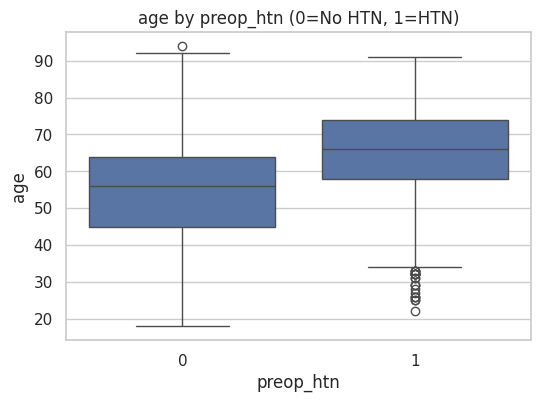

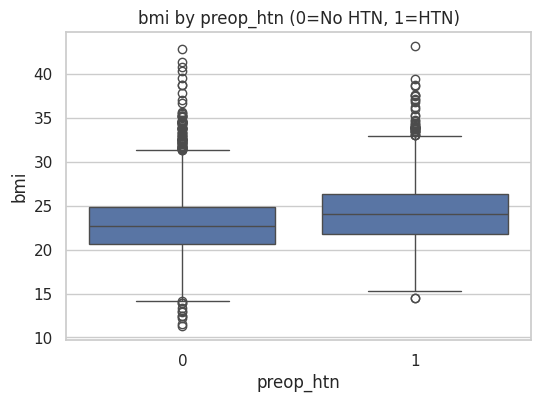

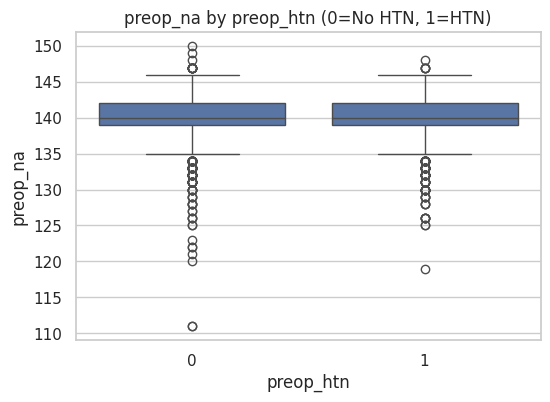

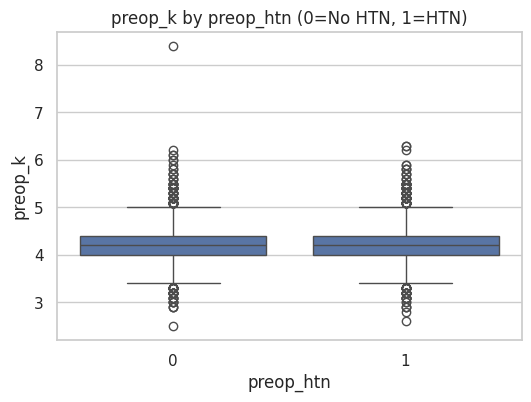

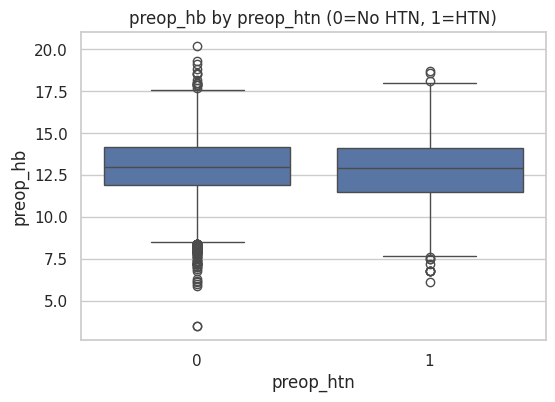

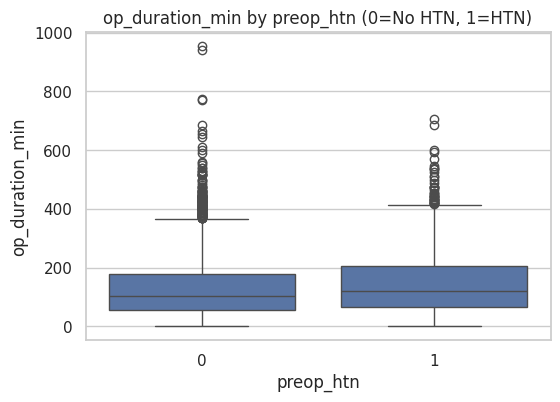

In [15]:
# 5-1. 연속형: boxplot
plot_cols = ["age", "bmi", "preop_na", "preop_k", "preop_hb", "op_duration_min"]
plot_cols = [c for c in plot_cols if c in df.columns]

for col in plot_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="preop_htn", y=col)
    plt.title(f"{col} by preop_htn (0=No HTN, 1=HTN)")
    plt.xlabel("preop_htn")
    plt.ylabel(col)
    plt.show()


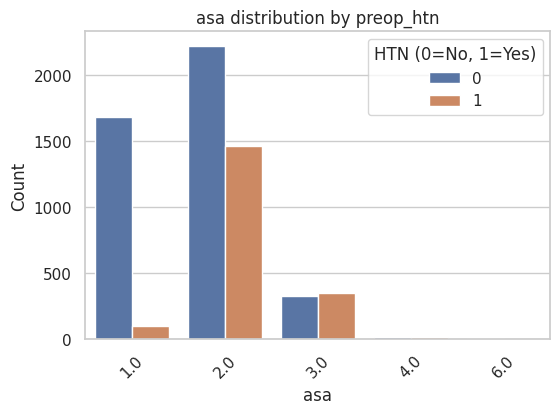

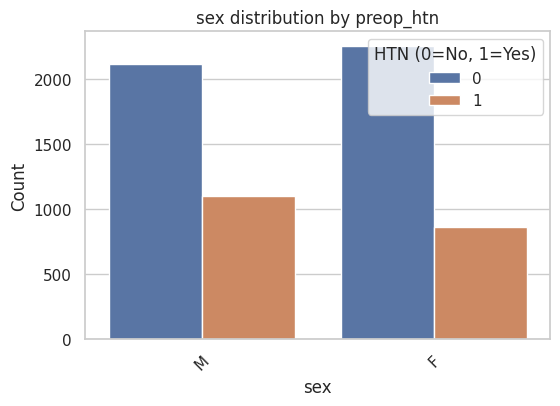

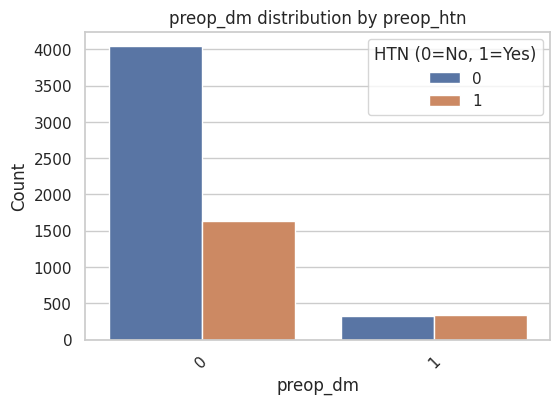

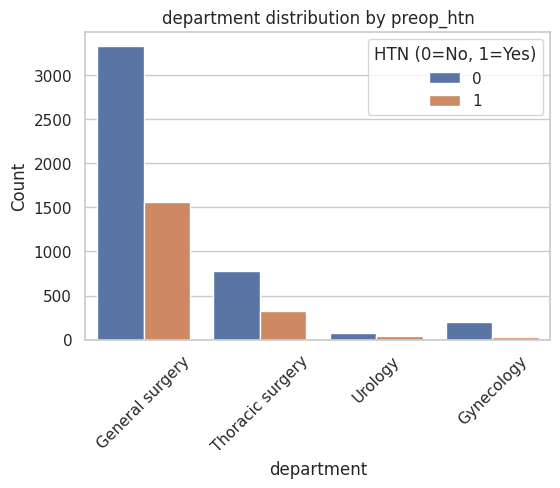

In [16]:
# 5-2. 범주형: countplot
cat_plot_cols = ["asa", "sex", "preop_dm", "department"]
cat_plot_cols = [c for c in cat_plot_cols if c in df.columns]

for col in cat_plot_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, hue="preop_htn")
    plt.title(f"{col} distribution by preop_htn")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="HTN (0=No, 1=Yes)")
    plt.show()


## 6. EDA 3: 통계 검정 (Mann–Whitney & Chi-square)

In [17]:
# 6-1. 연속형 변수: Mann-Whitney U test
df0 = df[df["preop_htn"] == 0]
df1 = df[df["preop_htn"] == 1]

print("=== Mann-Whitney U test (numeric vars) ===")
for col in num_cols:
    try:
        stat, p = mannwhitneyu(df0[col], df1[col], alternative="two-sided")
        print(f"{col:20s} p-value = {p:.4f}")
    except Exception as e:
        print(f"{col:20s} ERROR: {e}")

=== Mann-Whitney U test (numeric vars) ===
age                  p-value = 0.0000
bmi                  p-value = 0.0000
preop_hb             p-value = 0.0000
preop_plt            p-value = 0.0058
preop_pt             p-value = 0.0000
preop_aptt           p-value = 0.0000
preop_na             p-value = 0.2445
preop_k              p-value = 0.4921
preop_gluc           p-value = 0.0000
op_duration_min      p-value = 0.0000
ane_duration_min     p-value = 0.0000


In [18]:
# 6-2. 범주형 변수: Chi-square test
print("\n=== Chi-square test (categorical vars) ===")
for col in cat_cols:
    table = pd.crosstab(df[col], df["preop_htn"])
    chi2, p, dof, exp = chi2_contingency(table)
    print(f"{col:20s} p-value = {p:.4f}")


=== Chi-square test (categorical vars) ===
sex                  p-value = 0.0000
department           p-value = 0.0000
optype               p-value = 0.0000
asa                  p-value = 0.0000
emop                 p-value = 0.1174
preop_dm             p-value = 0.0000


## 7. 회귀 1: statsmodels Logistic Regression (고혈압 ~ 임상 변수)

In [21]:
df_reg.dtypes.head(30)

age                            float64
bmi                            float64
preop_hb                       float64
preop_plt                      float64
preop_pt                       float64
preop_aptt                     float64
preop_na                       float64
preop_k                        float64
preop_gluc                     float64
op_duration_min                float64
ane_duration_min               float64
preop_htn                        int64
sex_M                             bool
department_Gynecology             bool
department_Thoracic surgery       bool
department_Urology                bool
optype_Breast                     bool
optype_Colorectal                 bool
optype_Hepatic                    bool
optype_Major resection            bool
optype_Minor resection            bool
optype_Others                     bool
optype_Stomach                    bool
optype_Thyroid                    bool
optype_Transplantation            bool
optype_Vascular          

In [22]:
# 7-1. 회귀에 사용할 피처들 다시 정의
features_num = num_cols.copy()
features_cat = cat_cols.copy()

# 7-2. one-hot 인코딩
df_reg = df[features_num + features_cat + ["preop_htn"]].copy()
df_reg = pd.get_dummies(df_reg, columns=features_cat, drop_first=True)

# bool → int 변환
df_reg = df_reg.replace({True: 1, False: 0})

# 결측 제거
df_reg = df_reg.dropna()

# y, X 분리
y = df_reg["preop_htn"].astype(int)
X = df_reg.drop(columns=["preop_htn"])

# 상수항 추가
X_const = sm.add_constant(X).astype(float)

# 7-3. Logistic Regression
logit_model = sm.Logit(y, X_const)
result = logit_model.fit(disp=False)

result.summary()


/tmp/ipykernel_1042145/429851897.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reg = df_reg.replace({True: 1, False: 0})


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6299
Method:                           MLE   Df Model:                           31
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.2356
Time:                        12:54:41   Log-Likelihood:                -2996.8
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -8.3296      1.747     -4.768      0.000     -11.753      -4.906
age                             0.0596      0.003     20.181      0.000       0.054       0.065
bmi                             0.1385      0.010     14.201      0.000       0.119       0.158
preop_hb                       -0.0078      0.020     -0.395      0.693      -0.046       0.031
preop_plt                       0.0018      0.000      4.458      0.000       0.001       0.003
preop_pt                        0.0168      0.002      7.022      0.000       0.012       0.021
preop_aptt                      0.0015      0.004      0.343      0.732      -0.007       0.010
preop_na                       -0.0188      0.012     -1.571      0.116      -0.042       0.005
preop_k                        -0.1223      0.083     -1.470      0.142      -0.285       0.041
preop_gluc                      0.0001      0.001      0.176      0.860      -0.001       0.002
op_duration_min                 0.0002      0.001      0.179      0.858      -0.002       0.003
ane_duration_min               -0.0002      0.001     -0.144      0.886      -0.003       0.002
sex_M                           0.0913      0.074      1.236      0.216      -0.053       0.236
department_Gynecology          -0.4385      0.299     -1.467      0.142      -1.024       0.147
department_Thoracic surgery    -0.2896      0.193     -1.497      0.134      -0.669       0.090
department_Urology             -0.1848      0.301     -0.614      0.539      -0.775       0.405
optype_Breast                  -0.0228      0.171     -0.134      0.894      -0.357       0.312
optype_Colorectal              -0.0221      0.113     -0.195      0.845      -0.243       0.199
optype_Hepatic                 -0.0983      0.175     -0.562      0.574      -0.441       0.244
optype_Major resection          0.0594      0.239      0.249      0.804      -0.409       0.527
optype_Minor resection         -0.1035      0.240     -0.432      0.666      -0.574       0.367
optype_Others                  -0.1806      0.151     -1.197      0.231      -0.477       0.115
optype_Stomach                  0.1701      0.134      1.271      0.204      -0.092       0.432
optype_Thyroid                 -0.0643      0.199     -0.323      0.747      -0.455       0.326
optype_Transplantation          0.8519      0.184      4.620      0.000       0.491       1.213
optype_Vascular                 0.3472      0.177      1.966      0.049       0.001       0.693
asa_2.0                         1.9406      0.104     18.627      0.000       1.736       2.145
asa_3.0                         2.5359      0.140     18.089      0.000       2.261       2.811
asa_4.0                         2.1935      0.403      5.443      0.000       1.404       2.983
asa_6.0                         1.6522      0.995      1.660      0.097      -0.298       3.603
emop_1                          0.2458      0.104      2.361      0.018  

In [23]:
# 7-4. 계수 + 오즈비(odds ratio) 정리
coef = result.params
pvals = result.pvalues

odds = np.exp(coef)
summary_table = pd.DataFrame({
    "coef": coef,
    "odds_ratio": odds,
    "p_value": pvals
}).sort_values("odds_ratio", ascending=False)

summary_table.head(20)

,coef,odds_ratio,p_value
asa_3.0,2.535931,12.628181,3.918037e-73
asa_4.0,2.193486,8.966412,5.251746e-08
asa_2.0,1.940572,6.962734,1.943570e-77
asa_6.0,1.652150,5.218187,9.689550e-02
optype_Transplantation,0.851944,2.344200,3.837347e-06
optype_Vascular,0.347166,1.415052,4.930314e-02
emop_1,0.245751,1.278581,1.821027e-02
preop_dm_1,0.206830,1.229773,3.333892e-02
optype_Stomach,0.170101,1.185425,2.037329e-01
bmi,0.138486,1.148534,9.065777e-46


## 8. 시각화: 상위 중요한 피처들 오즈비 플롯

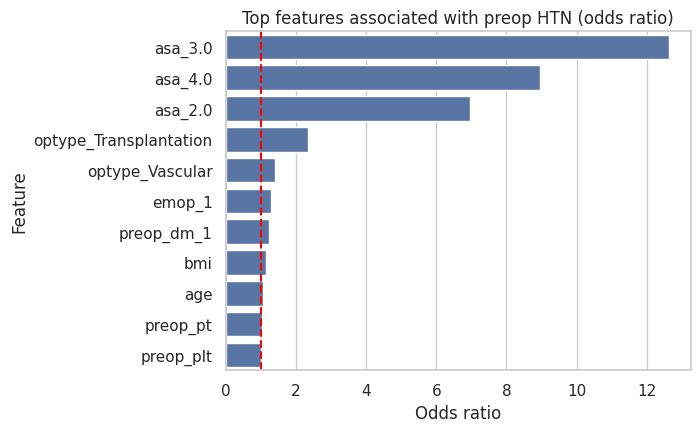

In [24]:
# 8-1. 유의한 피처들만 (p < 0.05) 골라서 시각화
sig = summary_table[(summary_table["p_value"] < 0.05) & (summary_table.index != "const")]

top_n = 15
sig_top = sig.sort_values("odds_ratio", ascending=False).head(top_n)

plt.figure(figsize=(6, 0.4*len(sig_top)))
sns.barplot(x="odds_ratio", y=sig_top.index, data=sig_top)
plt.axvline(1.0, color="red", linestyle="--")
plt.title("Top features associated with preop HTN (odds ratio)")
plt.xlabel("Odds ratio")
plt.ylabel("Feature")
plt.show()


**(1) ASA가 압도적인 predictor**

coef:\
ASA 2 → OR ≈ 6.96\
ASA 3 → OR ≈ 12.6\
ASA 4 → OR ≈ 8.96\
즉.
ASA가 1 증가할 때, 고혈압일 확률 증가

**(2) 수술 종류(optype), 특히 Transplantation / Vascular 도 predictor**

이 과들에서 고혈압 환자 비율이 높음\
병력 특성(만성 질환)이 수술 종류와 매칭

결론: 고혈압 환자들은 특정 major surgery (이식/혈관)로 더 자주 들어온다.

*Transplantation Surgery _ 이식 수술\
*Vascular Surgery _ 혈관 수술 

**(3) 나이, BMI는 모두 강력 predictor (p<1e-40)**\
age → OR=1.06\
BMI → OR=1.15\
나이 10세 증가할 때, 고혈압 위험 ≈ 1.8배.\
BMI 증가 5 → 고혈압 위험 약 2배.

**(4) 실험실 수치(PT, plt)는 통계적으로는 유의하지만 임상적 효과는 미약**\
PT → OR 1.016 (매우 작은 영향)\
plt → OR 1.001 (임상적 의미 거의 없음)

**결론**\
고혈압 비례 with 고위험군(ASA), 고령, BMI, diabetes랑 연관

---

# Part B

### B1. window-level ECG v4 데이터 로딩 + 기본 필터링

In [26]:
WIN_PATH = "data/processed/ecg_labels_all_cases_v4.csv"

df_win = pd.read_csv(WIN_PATH)
print(df_win.shape)
df_win.head()


(14406493, 24)


,caseid,tid,start_time,end_time,quality_score,hr_mean,hr_max,hr_min,sdnn,rmssd,arrhythmia,reasons,sdnn_thr,rmssd_thr,sdnn_mean_case,sdnn_std_case,rmssd_mean_case,rmssd_std_case,sdnn_z_case,rmssd_z_case,is_tachy_v4,is_brady_v4,is_irregular_v4,arrhythmia_v4
0,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,0.0,10.0,0.990999,133.164169,236.220472,58.252427,0.213661,0.255259,1,"{'brady': False, 'tachy': True, 'irregular': False, 'rapid_fluct': True}",0.233341,0.267214,0.061393,0.085983,0.072852,0.09719,1.770908,1.876809,False,False,False,0
1,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,5.0,15.0,0.984610,164.070761,240.000000,30.518820,0.538156,0.852530,1,"{'brady': False, 'tachy': True, 'irregular': True, 'rapid_fluct': True}",0.233341,0.267214,0.061393,0.085983,0.072852,0.09719,5.544860,8.022178,True,False,False,1
2,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,10.0,20.0,0.987009,176.471757,240.000000,28.517110,0.503532,0.464563,1,"{'brady': False, 'tachy': True, 'irregular': True, 'rapid_fluct': True}",0.233341,0.267214,0.061393,0.085983,0.072852,0.09719,5.142175,4.030356,True,False,False,1
3,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,15.0,25.0,0.994900,96.175014,198.675497,40.760870,0.302524,0.357963,1,"{'brady': False, 'tachy': False, 'irregular': True, 'rapid_fluct': True}",0.233341,0.267214,0.061393,0.085983,0.072852,0.09719,2.804404,2.933534,False,False,True,1
4,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,20.0,30.0,0.992200,87.453865,119.047619,55.248619,0.144788,0.235485,1,"{'brady': False, 'tachy': False, 'irregular': False, 'rapid_fluct': True}",0.233341,0.267214,0.061393,0.085983,0.072852,0.09719,0.969904,1.673352,False,False,False,0


### B1-2. 컬럼 정보 / 결측률 확인

In [28]:
print(df_win.columns)

(df_win.isna().mean() * 100).round(1).sort_values(ascending=False)

Index(['caseid', 'tid', 'start_time', 'end_time', 'quality_score', 'hr_mean',
       'hr_max', 'hr_min', 'sdnn', 'rmssd', 'arrhythmia', 'reasons',
       'sdnn_thr', 'rmssd_thr', 'sdnn_mean_case', 'sdnn_std_case',
       'rmssd_mean_case', 'rmssd_std_case', 'sdnn_z_case', 'rmssd_z_case',
       'is_tachy_v4', 'is_brady_v4', 'is_irregular_v4', 'arrhythmia_v4'],
      dtype='object')


sdnn_thr           5.9
rmssd_thr          5.5
caseid             0.0
tid                0.0
quality_score      0.0
hr_mean            0.0
start_time         0.0
end_time           0.0
hr_min             0.0
hr_max             0.0
sdnn               0.0
rmssd              0.0
reasons            0.0
arrhythmia         0.0
sdnn_mean_case     0.0
sdnn_std_case      0.0
rmssd_mean_case    0.0
rmssd_std_case     0.0
sdnn_z_case        0.0
rmssd_z_case       0.0
is_tachy_v4        0.0
is_brady_v4        0.0
is_irregular_v4    0.0
arrhythmia_v4      0.0
dtype: float64

### B1-3. 핵심 컬럼만 우선 서브셋 

In [30]:
cols_keep_win = [
    "caseid",
    "tid",              # 있으면
    "start_time", "end_time",   # 있으면
    "quality_score",
    "hr_mean", "hr_max", "hr_min",
    "sdnn", "rmssd",
    # arrhythmia 관련 컬럼은 나중에 쓸 수도 있으니 일단 유지
    "arrhythmia", "arrhythmia_v4",
    # 시간축 관련 컬럼이 있으면 같이 사용
    "window_idx", "w_start_sec", "w_end_sec"
]

cols_keep_win = [c for c in cols_keep_win if c in df_win.columns]
df_win = df_win[cols_keep_win].copy()

print("윈도우 데이터 shape:", df_win.shape)
df_win.head()


윈도우 데이터 shape: (14406493, 12)


,caseid,tid,start_time,end_time,quality_score,hr_mean,hr_max,hr_min,sdnn,rmssd,arrhythmia,arrhythmia_v4
0,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,0.0,10.0,0.990999,133.164169,236.220472,58.252427,0.213661,0.255259,1,0
1,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,5.0,15.0,0.984610,164.070761,240.000000,30.518820,0.538156,0.852530,1,1
2,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,10.0,20.0,0.987009,176.471757,240.000000,28.517110,0.503532,0.464563,1,1
3,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,15.0,25.0,0.994900,96.175014,198.675497,40.760870,0.302524,0.357963,1,1
4,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,20.0,30.0,0.992200,87.453865,119.047619,55.248619,0.144788,0.235485,1,0


### B1-4. quality_score 기반 필터링 (품질이 너무 나쁜 윈도우 제거)

In [32]:
if "quality_score" in df_win.columns:
    print("quality_score 분포:")
    print(df_win["quality_score"].describe())

    # 품질 좋은 구간만 사용 (예: 0.8 이상)
    thr_quality = 0.8
    n_before_q = len(df_win)
    df_win = df_win[df_win["quality_score"] >= thr_quality].copy()
    n_after_q = len(df_win)
    print(f"\n품질 필터링: {n_before_q} -> {n_after_q} 윈도우 (quality >= {thr_quality})")
else:
    print("quality_score 컬럼이 없습니다. 일단 전체 윈도우를 사용합니다.")

quality_score 분포:
count    1.440649e+07
mean     8.337364e-01
std      7.137815e-02
min      6.949925e-01
25%      7.881064e-01
50%      8.264855e-01
75%      8.737452e-01
max      1.000000e+00
Name: quality_score, dtype: float64

품질 필터링: 14406493 -> 9730977 윈도우 (quality >= 0.8)


### B1-5. HR / HRV 핵심 수치들 결측 제거

In [33]:
core_cols = [c for c in ["hr_mean", "sdnn", "rmssd"] if c in df_win.columns]

n_before_core = len(df_win)
df_win = df_win.dropna(subset=core_cols)
n_after_core = len(df_win)

print(f"HR/HRV 핵심 컬럼 결측 제거: {n_before_core} -> {n_after_core} 윈도우")
df_win[core_cols].describe()


HR/HRV 핵심 컬럼 결측 제거: 9730977 -> 9728704 윈도우


,hr_mean,sdnn,rmssd
count,9.728704e+06,9.728704e+06,9.728704e+06
mean,1.457584e+02,1.494719e-01,2.611804e-01
std,2.743158e+01,1.002065e-01,1.621460e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.320088e+02,9.663347e-02,1.666152e-01
50%,1.487964e+02,1.455958e-01,2.534772e-01
75%,1.640211e+02,1.931027e-01,3.455329e-01
max,2.400000e+02,6.549223e+00,9.262000e+00


### B2: window-level ECG 데이터에 고혈압 레이블
(preop_htn) 붙이기

**df_win (ECG window-level)\
df (case-level features 포함)**\
을 caseid로 merge해서 window에 고혈압 여부를 붙이는 과정.

### B2 코드: merge (caseid 기준)

In [34]:
# B2-1. merge: ECG window-level 데이터에 preop_htn 붙이기

df_merged = df_win.merge(
    df[["caseid", "preop_htn"]], 
    on="caseid", 
    how="left"
)

print(df_merged.shape)
df_merged.head()

(9728704, 13)


,caseid,tid,start_time,end_time,quality_score,hr_mean,hr_max,hr_min,sdnn,rmssd,arrhythmia,arrhythmia_v4,preop_htn
0,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,0.0,10.0,0.990999,133.164169,236.220472,58.252427,0.213661,0.255259,1,0,1.0
1,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,5.0,15.0,0.984610,164.070761,240.000000,30.518820,0.538156,0.852530,1,1,1.0
2,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,10.0,20.0,0.987009,176.471757,240.000000,28.517110,0.503532,0.464563,1,1,1.0
3,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,15.0,25.0,0.994900,96.175014,198.675497,40.760870,0.302524,0.357963,1,1,1.0
4,1,8c9161aaae8cb578e2aa7b60f44234d98d2b3344,20.0,30.0,0.992200,87.453865,119.047619,55.248619,0.144788,0.235485,1,0,1.0


### B2-2. 병합 후 sanity check (유효한가?)

In [35]:
# HTN의 분포 확인 (window-level 기준)

htn_counts = df_merged["preop_htn"].value_counts(dropna=False)
htn_ratio = df_merged["preop_htn"].value_counts(normalize=True) * 100

print("=== Window-level HTN count ===")
print(htn_counts)
print("\n=== Window-level HTN ratio (%) ===")
print(htn_ratio)


=== Window-level HTN count ===
preop_htn
0.0    6547327
1.0    3059536
NaN     121841
Name: count, dtype: int64

=== Window-level HTN ratio (%) ===
preop_htn
0.0    68.152601
1.0    31.847399
Name: proportion, dtype: float64


### B2-3. 윈도우 수 비교

In [36]:
df_merged.groupby("preop_htn")["caseid"].count()


preop_htn
0.0    6547327
1.0    3059536
Name: caseid, dtype: int64

### B2-4. HR / HRV 기본 통계 비교

In [37]:
numeric = ["hr_mean", "sdnn", "rmssd"]
df_merged.groupby("preop_htn")[numeric].describe()

hr_mean                                                      \
               count        mean        std  min         25%         50%   
preop_htn                                                                  
0.0        6547327.0  146.392520  26.955606  0.0  133.070818  149.554276   
1.0        3059536.0  144.303642  28.023828  0.0  130.394575  147.221032   

                                   sdnn                                    \
                  75%    max      count      mean      std  min       25%   
preop_htn                                                                   
0.0        164.459231  240.0  6547327.0  0.148923  0.09953  0.0  0.096835   
1.0        162.759444  240.0  3059536.0  0.153433  0.10090  0.0  0.099905   

                                             rmssd                           \
                50%       75%       max      count      mean       std  min   
preop_htn                                                                     
0.0        0.145383  0.191886  6.390831  6547327.0  0.261249  0.161442  0.0   
1.0        0.148376  0.197434  6.549223  3059536.0  0.266523  0.161754  0.0   

                                                
                25%       50%       75%    max  
preop_htn                                       
0.0        0.167301  0.254029  0.345493  9.038  
1.0        0.172587  0.256921  0.348807  9.262

고혈압 환자 vs 일반 환자의 수술 중 HR_mean / HRV는 마취/수술 컨텍스트에 의해 flatten되므로 큰 차이가 안 보임 (정상)

### B3-0. 시각화용 데이터 준비 (NaN 제거 + 샘플링)

In [38]:
sns.set(style="whitegrid")

# 0) preop_htn 없는 윈도우는 제거
df_ecg = df_merged.dropna(subset=["preop_htn"]).copy()

# float → int로 바꿔주면 보기 편함
df_ecg["preop_htn"] = df_ecg["preop_htn"].astype(int)

print(df_ecg["preop_htn"].value_counts())


preop_htn
0    6547327
1    3059536
Name: count, dtype: int64


In [39]:
# 1) 시각화용 샘플링 (그대로 다 그리면 너무 크니까)
#    그룹당 최대 200,000개 정도만 사용 (원하면 숫자 줄여도 됨)

sample_per_group = 200_000

df_plot = (
    df_ecg
    .groupby("preop_htn", group_keys=False)
    .apply(lambda x: x.sample(
        n=min(sample_per_group, len(x)), 
        random_state=42
    ))
)

df_plot.shape


/tmp/ipykernel_1042145/2168227439.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(


(400000, 13)

### B3-1. Boxplot: HR_mean / SDNN / RMSSD vs 고혈압 여부

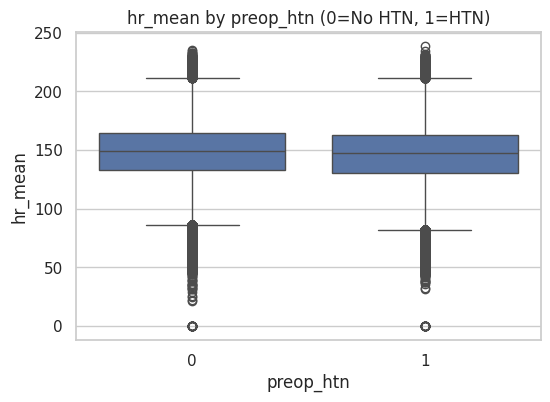

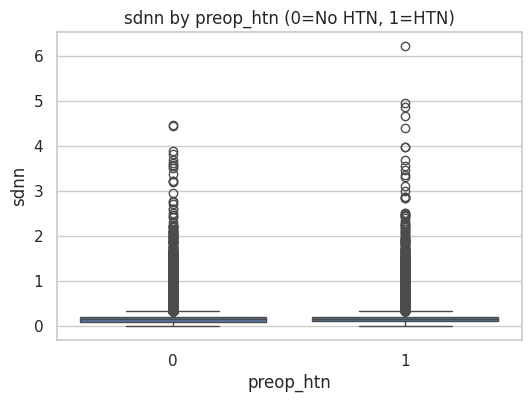

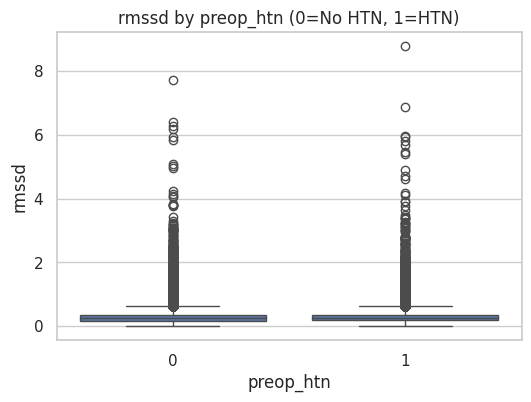

In [40]:
metrics = ["hr_mean", "sdnn", "rmssd"]
metrics = [m for m in metrics if m in df_plot.columns]

for col in metrics:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_plot, x="preop_htn", y=col)
    plt.title(f"{col} by preop_htn (0=No HTN, 1=HTN)")
    plt.xlabel("preop_htn")
    plt.ylabel(col)
    plt.show()

### B3-2. KDE Plot (분포 비교)

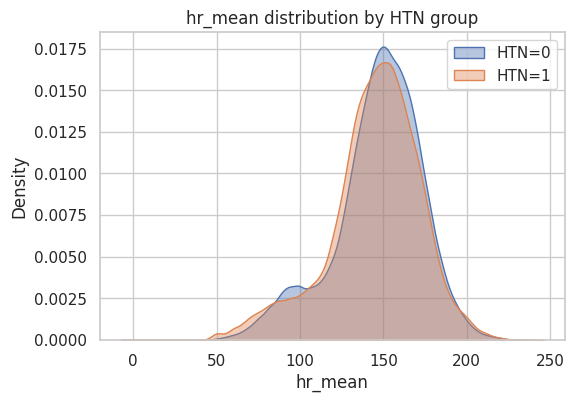

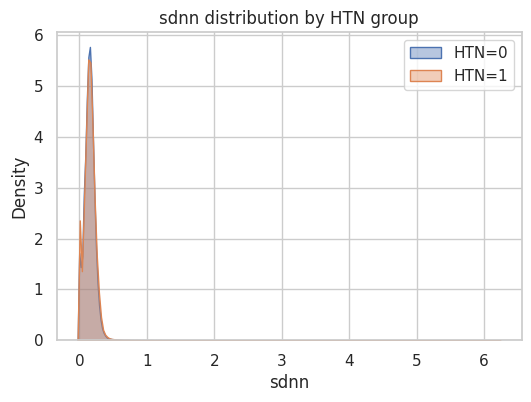

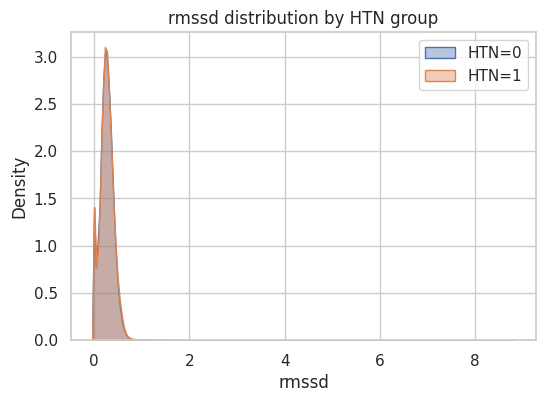

In [41]:
for col in metrics:
    plt.figure(figsize=(6,4))
    sns.kdeplot(
        data=df_plot[df_plot["preop_htn"] == 0],
        x=col,
        label="HTN=0",
        fill=True,
        alpha=0.4
    )
    sns.kdeplot(
        data=df_plot[df_plot["preop_htn"] == 1],
        x=col,
        label="HTN=1",
        fill=True,
        alpha=0.4
    )
    plt.title(f"{col} distribution by HTN group")
    plt.xlabel(col)
    plt.legend()
    plt.show()


### B3-3. Violin plot (조금 더 shape이 잘 보이는 버전, 선택사항)

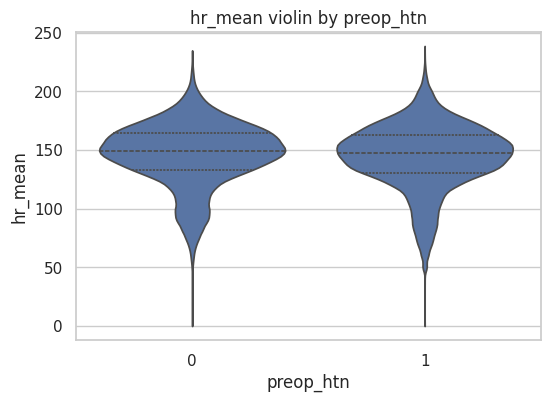

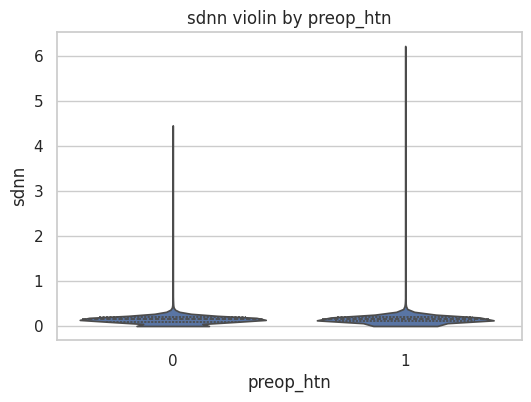

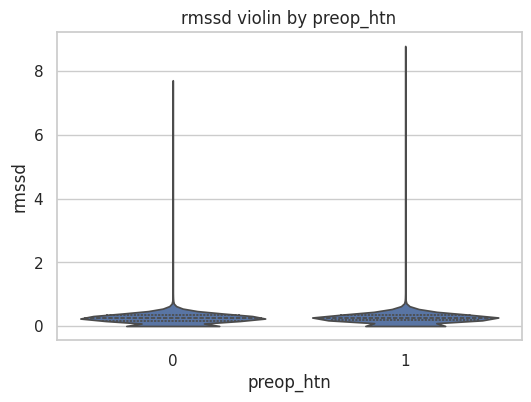

In [42]:
for col in metrics:
    plt.figure(figsize=(6,4))
    sns.violinplot(
        data=df_plot,
        x="preop_htn",
        y=col,
        inner="quartile",
        cut=0
    )
    plt.title(f"{col} violin by preop_htn")
    plt.xlabel("preop_htn")
    plt.ylabel(col)
    plt.show()

전신마취는 자율신경계 tone을 강하게 억제하고
surgical stimulation, ventilator settings, vasoactive drug 등
intraoperative dynamic factor가 HR/HRV 변동의 대부분을 explain한다.
따라서 HTN 여부에 따른 HR/HRV window-level 차이는 통계적으로 거의 나타나지 않았다.

### B4. 대표 케이스 1:1 Time-series 시각화

In [43]:
# HTN=0 and HTN=1 케이스 선택 (윈도우 수가 충분한 케이스 우선 만 선택)

# 각 caseid가 가진 window 수 계산
case_counts = df_ecg.groupby(["caseid", "preop_htn"])["hr_mean"].count().reset_index()

# 윈도우 수 많은 순으로 정렬
case_counts = case_counts.sort_values("hr_mean", ascending=False)

# 정상군에서 window 많은 케이스 1개 선택
case_norm = case_counts[case_counts["preop_htn"] == 0]["caseid"].iloc[0]

# 고혈압군에서 window 많은 케이스 1개 선택
case_htn = case_counts[case_counts["preop_htn"] == 1]["caseid"].iloc[0]

case_norm, case_htn


(np.int64(1803), np.int64(5396))

In [44]:
cdf_norm = df_ecg[df_ecg["caseid"] == case_norm].copy()
cdf_htn  = df_ecg[df_ecg["caseid"] == case_htn].copy()

cdf_norm.shape, cdf_htn.shape


((12223, 13), (7440, 13))

In [45]:
def get_time_axis(cdf):
    if "w_start_sec" in cdf.columns:
        return cdf["w_start_sec"].values
    elif "window_idx" in cdf.columns:
        return cdf["window_idx"].values
    else:
        return np.arange(len(cdf))

cdf_norm["t"] = get_time_axis(cdf_norm)
cdf_htn["t"]  = get_time_axis(cdf_htn)


In [46]:
import matplotlib.pyplot as plt

def plot_case_ecg(cdf, title=""):
    plt.figure(figsize=(14, 10))

    # --- 1. HR_mean ---
    plt.subplot(3,1,1)
    plt.plot(cdf["t"], cdf["hr_mean"], linewidth=0.7)
    plt.title(title + " — HR_mean")
    plt.xlabel("time")
    plt.ylabel("HR_mean")

    # --- 2. SDNN ---
    plt.subplot(3,1,2)
    plt.plot(cdf["t"], cdf["sdnn"], linewidth=0.7, color="orange")
    plt.title(title + " — SDNN")
    plt.xlabel("time")
    plt.ylabel("SDNN")

    # --- 3. RMSSD ---
    plt.subplot(3,1,3)
    plt.plot(cdf["t"], cdf["rmssd"], linewidth=0.7, color="green")
    plt.title(title + " — RMSSD")
    plt.xlabel("time")
    plt.ylabel("RMSSD")

    plt.tight_layout()
    plt.show()


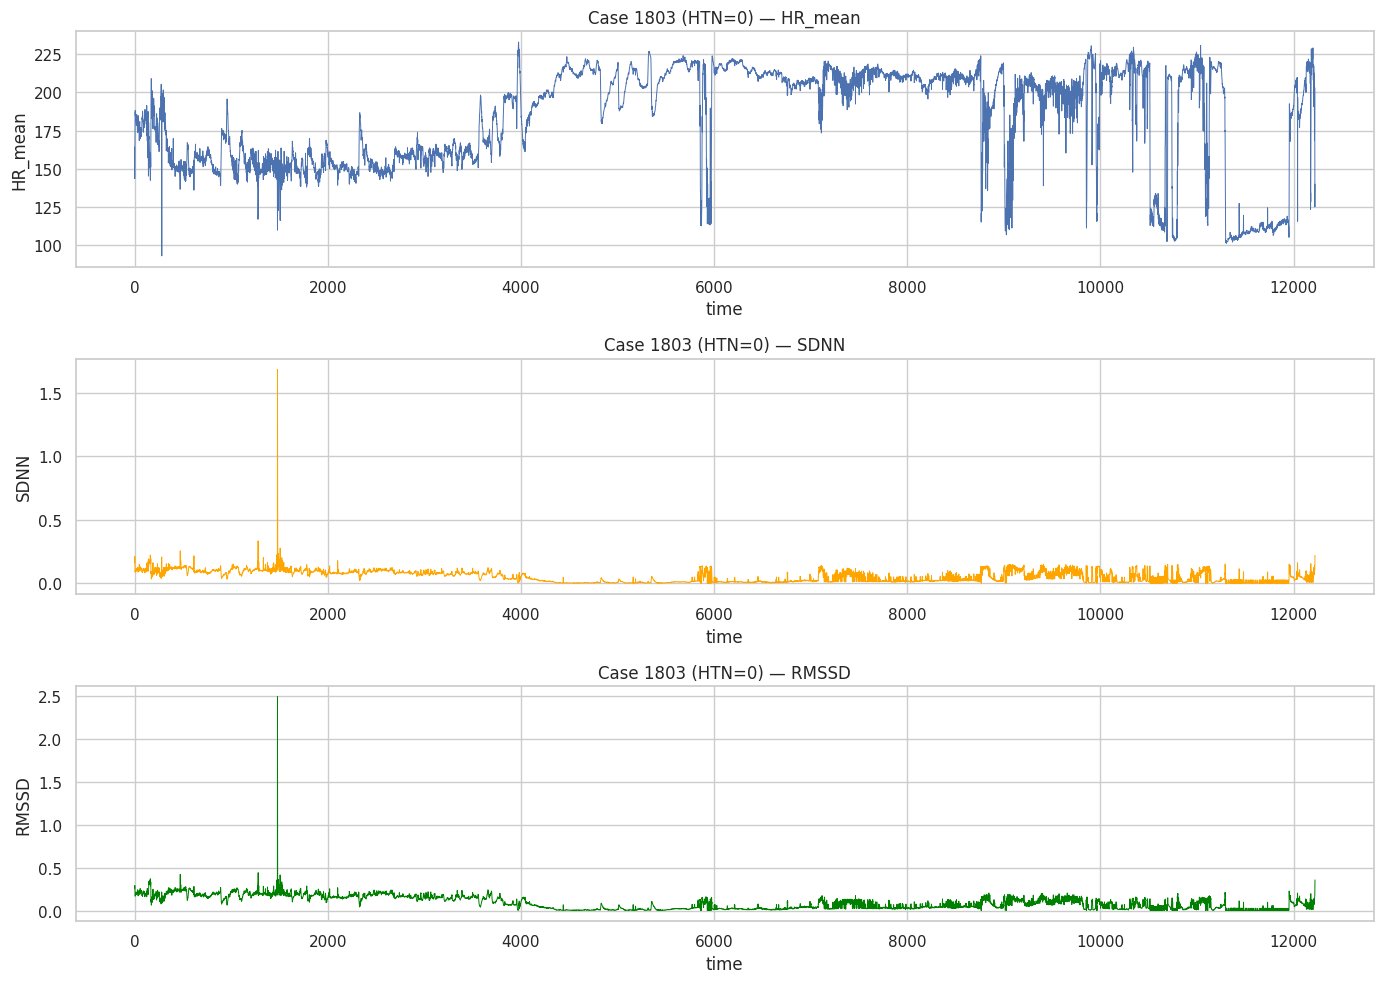

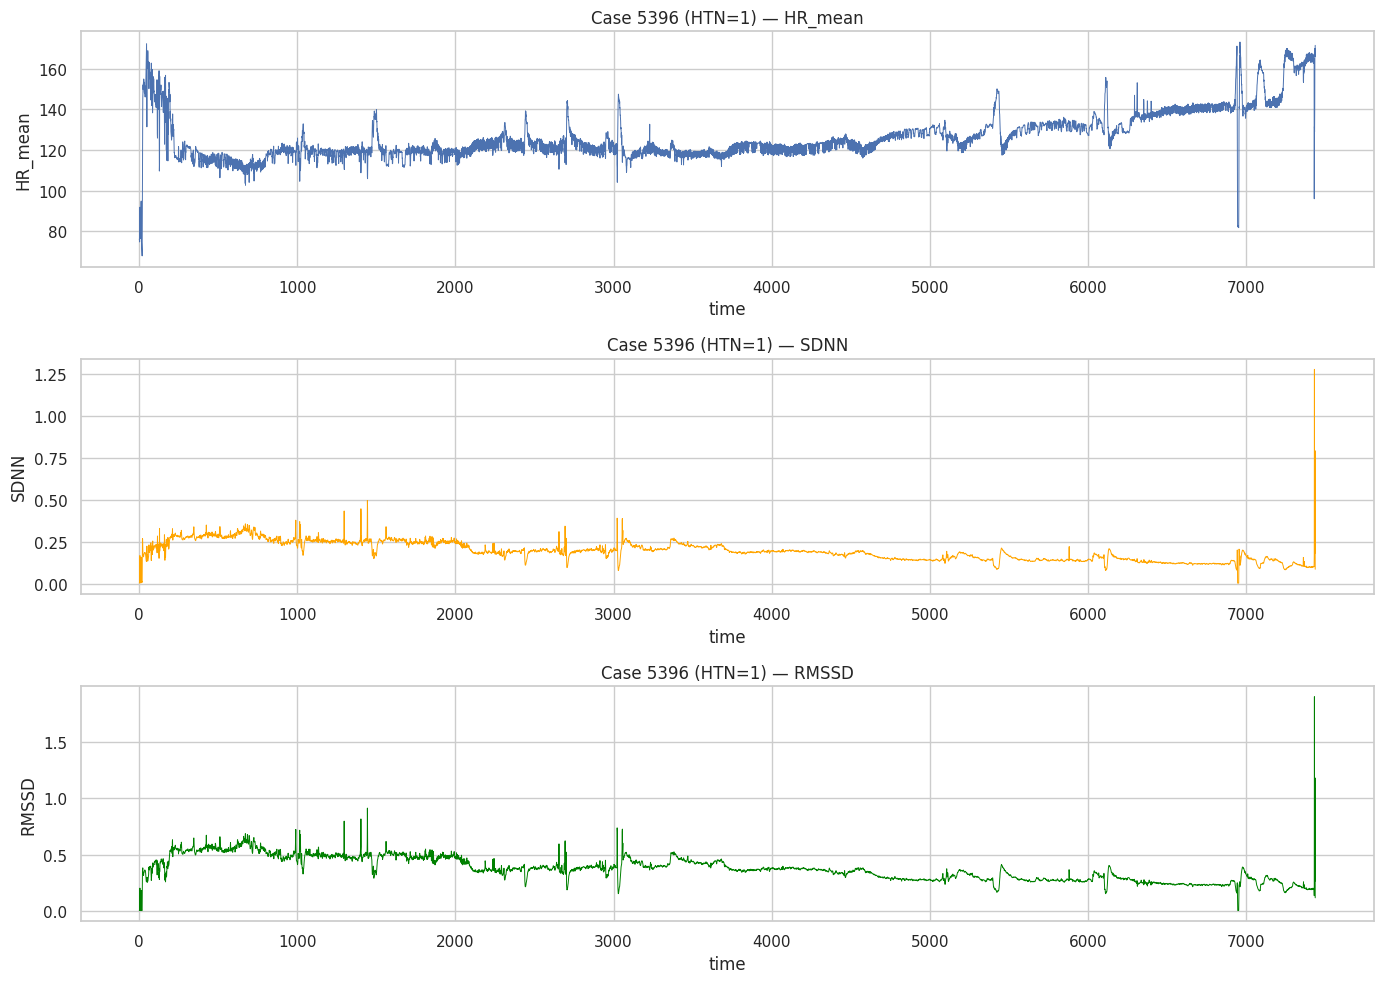

In [47]:
plot_case_ecg(cdf_norm, title=f"Case {case_norm} (HTN=0)")
plot_case_ecg(cdf_htn,  title=f"Case {case_htn} (HTN=1)")


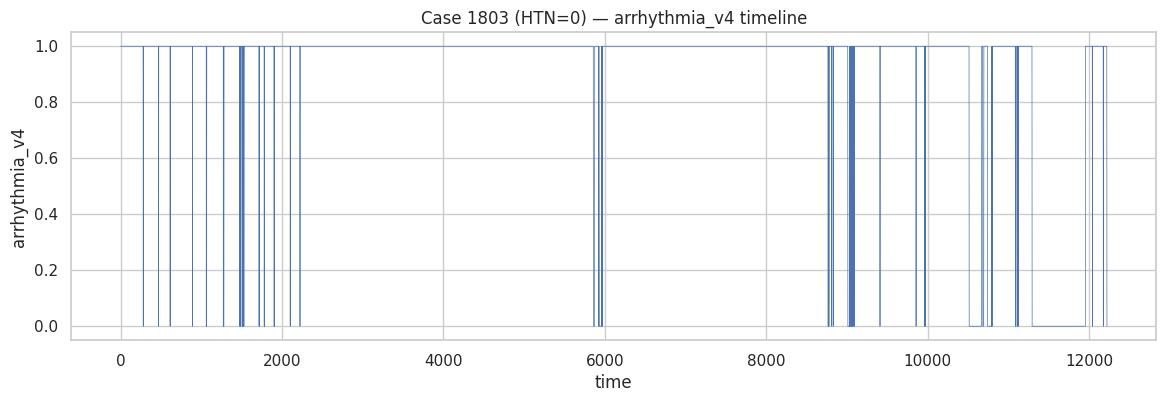

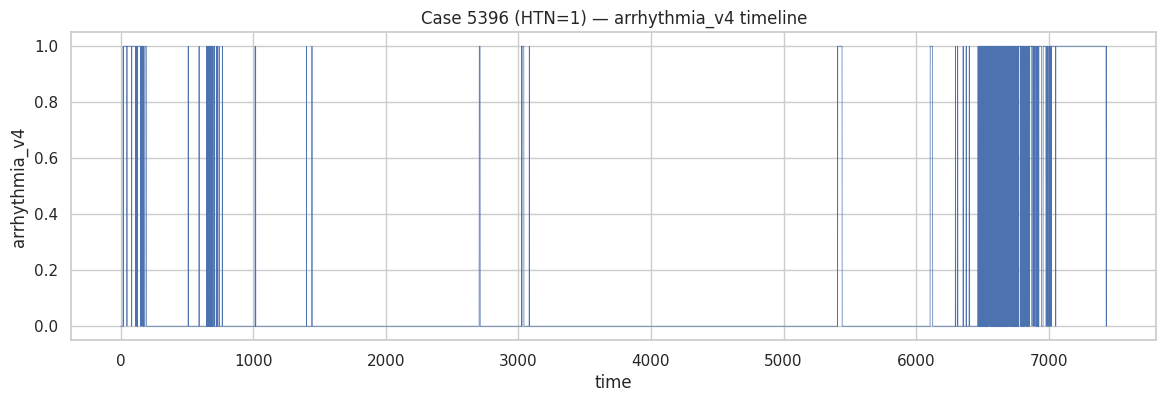

In [48]:
def plot_arrhythmia_overlay(cdf, title=""):
    plt.figure(figsize=(14,4))
    plt.plot(cdf["t"], cdf["arrhythmia_v4"], linewidth=0.5)
    plt.title(title + " — arrhythmia_v4 timeline")
    plt.xlabel("time")
    plt.ylabel("arrhythmia_v4")
    plt.show()

plot_arrhythmia_overlay(cdf_norm, f"Case {case_norm} (HTN=0)")
plot_arrhythmia_overlay(cdf_htn,  f"Case {case_htn} (HTN=1)")


In [49]:

CASE_IDS = [1803, 5396]

# VitalDB trks 테이블에서 ECG 트랙 찾기
trks = pd.read_csv("https://api.vitaldb.net/trks")

df_ecg_trks = (
    trks[
        (trks["caseid"].isin(CASE_IDS)) &
        (trks["tname"].str.contains("ECG", case=False, na=False))
    ]
    .loc[:, ["caseid", "tid", "tname"]]
    .drop_duplicates()
    .sort_values(["caseid", "tname"])
)

df_ecg_trks

,caseid,tid,tname
137680,1803,fcdac01ab7a2bcd1a3930bdf797d2ef475f628d4,SNUADC/ECG_II
410666,5396,2582932f4323907de1ca72bfb3b1b1e40e31ed50,SNUADC/ECG_II


In [50]:
# ECG 채널 이름 우선순위
priority = ["ECG_II", "SNUADC/ECG_II", "ECG_I", "ECG_III"]

def pick_ecg_track(df_case):
    # 우선순위 이름이 있으면 그걸, 아니면 첫 번째 ECG를 선택
    for name in priority:
        hit = df_case[df_case["tname"].str.contains(name, na=False)]
        if len(hit) > 0:
            return hit.iloc[0]
    return df_case.iloc[0]  # 그래도 없으면 그냥 첫 번째

picked_rows = []
for cid in CASE_IDS:
    sub = df_ecg_trks[df_ecg_trks["caseid"] == cid]
    if len(sub) == 0:
        print(f"[WARN] case {cid}: ECG track not found")
        continue
    picked_rows.append(pick_ecg_track(sub))

picked = pd.DataFrame(picked_rows)
picked


,caseid,tid,tname
137680,1803,fcdac01ab7a2bcd1a3930bdf797d2ef475f628d4,SNUADC/ECG_II
410666,5396,2582932f4323907de1ca72bfb3b1b1e40e31ed50,SNUADC/ECG_II


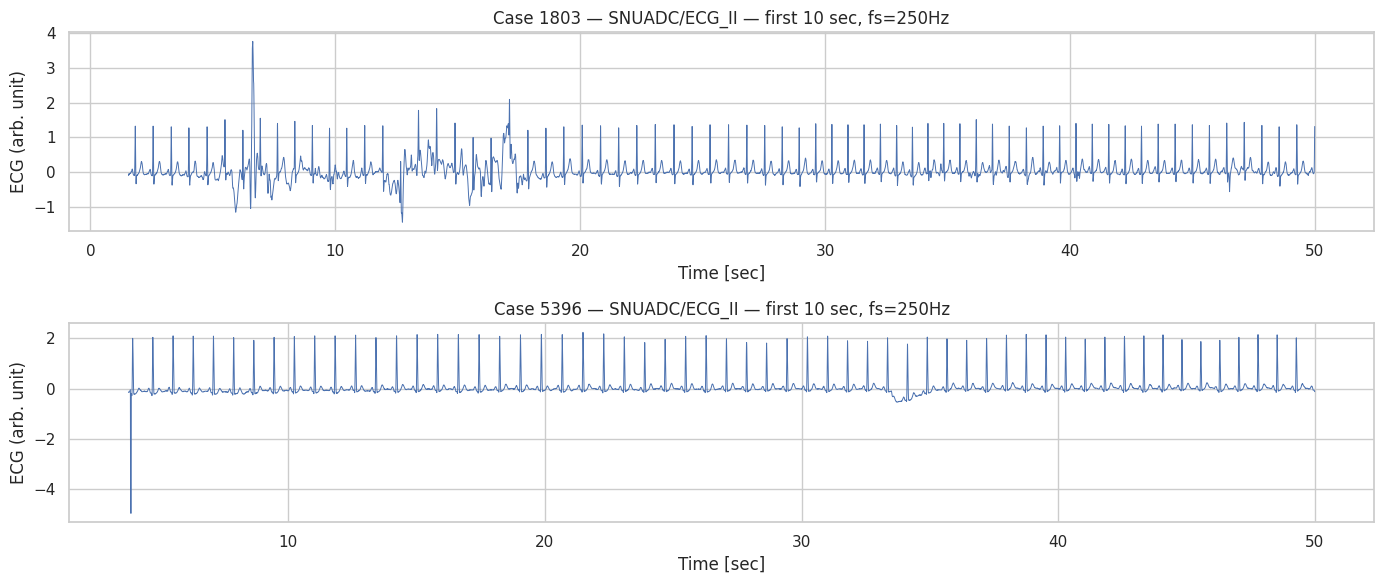

In [53]:
import vitaldb
import numpy as np
import matplotlib.pyplot as plt

fs = 250   # 최종 sampling rate (다운샘플링)
sec = 10   # 앞 10초만 보기

def load_ecg_by_trackname(case_id, track_name, fs=250, sec=10):
    # load_case returns shape (N, num_tracks)
    vals = vitaldb.load_case(int(case_id), [track_name], 1/fs)

    ecg = vals[:, 0]  # 첫 번째(유일한) 트랙
    n = min(len(ecg), fs * sec)
    ecg = ecg[:n]
    t = np.arange(n) / fs
    return t, ecg

fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=False)

for ax, row in zip(axes, picked.itertuples(index=False)):
    cid = int(row.caseid)
    tname = row.tname

    t, ecg = load_ecg_by_trackname(cid, tname, fs=fs, sec=50)

    ax.plot(t, ecg, linewidth=0.7)
    ax.set_title(f"Case {cid} — {tname} — first {sec} sec, fs={fs}Hz")
    ax.set_xlabel("Time [sec]")
    ax.set_ylabel("ECG (arb. unit)")

plt.tight_layout()
plt.show()


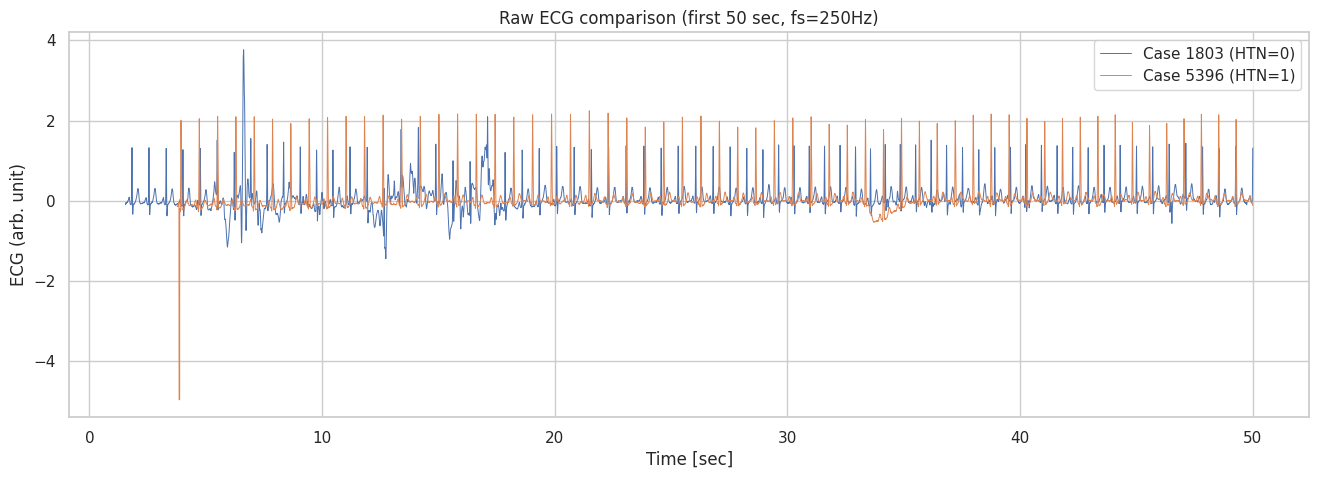

In [54]:
import numpy as np
import matplotlib.pyplot as plt

fs = 250   # Hz
sec = 50   # 50초 비교

def load_ecg_by_trackname(case_id, track_name, fs=250, sec=10):
    vals = vitaldb.load_case(int(case_id), [track_name], 1/fs)
    ecg = vals[:, 0]
    n = min(len(ecg), fs * sec)
    ecg = ecg[:n]
    t = np.arange(n) / fs
    return t, ecg

# caseid 기준으로 row 가져오기 (혹시 picked 순서가 바뀔 수도 있으니까)
row_norm = picked[picked["caseid"] == 1803].iloc[0]
row_htn  = picked[picked["caseid"] == 5396].iloc[0]

t_norm, ecg_norm = load_ecg_by_trackname(row_norm.caseid, row_norm.tname, fs=fs, sec=sec)
t_htn,  ecg_htn  = load_ecg_by_trackname(row_htn.caseid,  row_htn.tname,  fs=fs, sec=sec)

# 두 시계열 길이를 맞추기 (더 짧은 쪽 기준)
n = min(len(ecg_norm), len(ecg_htn))
t = np.arange(n) / fs
ecg_norm = ecg_norm[:n]
ecg_htn  = ecg_htn[:n]

plt.figure(figsize=(16,5))
plt.plot(t, ecg_norm, label="Case 1803 (HTN=0)", linewidth=0.7)
plt.plot(t, ecg_htn,  label="Case 5396 (HTN=1)", linewidth=0.7)

plt.title(f"Raw ECG comparison (first {sec} sec, fs={fs}Hz)")
plt.xlabel("Time [sec]")
plt.ylabel("ECG (arb. unit)")
plt.legend()
plt.grid(True)
plt.show()


case 1803: detected 10 peaks
case 5396: detected 59 peaks
=== HRV Comparison (raw ECG 기반) ===
Case 1803 (HTN=0): SDNN=6.2281, RMSSD=6.2562
Case 5396 (HTN=1): SDNN=0.0209, RMSSD=0.0060


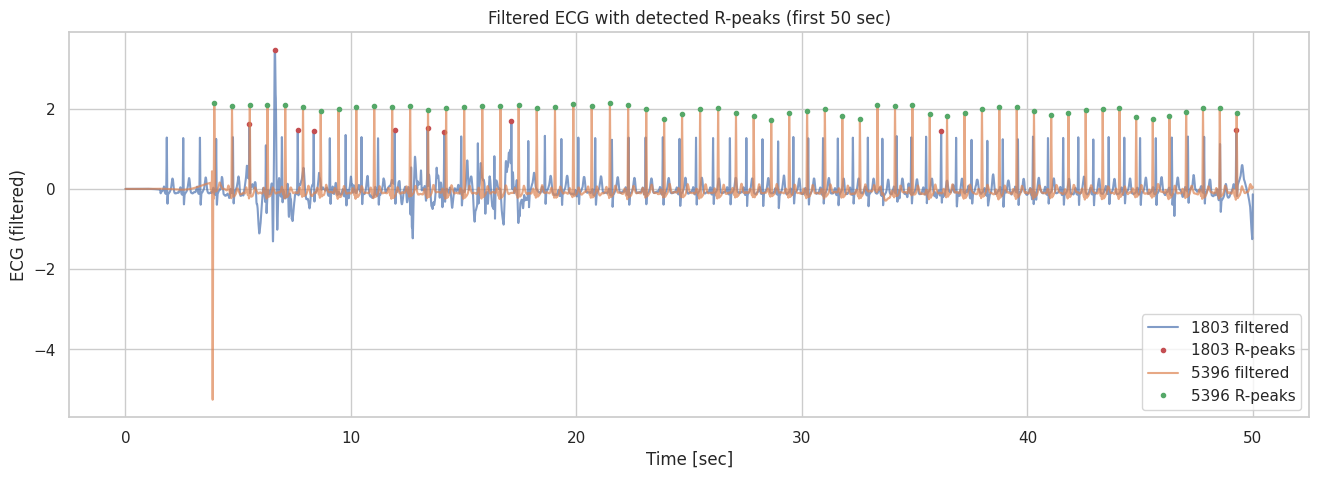

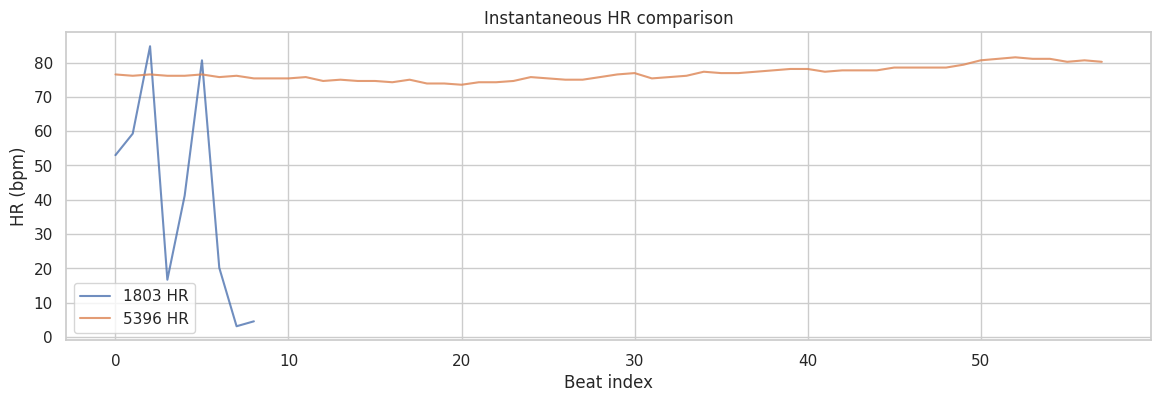

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

fs = 250
sec = 50

# 1) Bandpass filter
def bandpass_filter(sig, fs, low=0.5, high=40, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype="band")
    return filtfilt(b, a, sig)

# 2) R-peak detection (threshold를 max 기반으로)
def detect_r_peaks(ecg_f, fs):
    distance = int(0.25 * fs)  # 최소 RR 250ms
    # amplitude 기준을 mean+0.5*std 대신 max의 비율로
    height = np.max(ecg_f) * 0.4
    peaks, _ = find_peaks(ecg_f, distance=distance, height=height)
    return peaks

# 3) RR / HR / HRV 계산
def compute_rr_hr(peaks, fs):
    if len(peaks) < 3:
        return np.array([]), np.array([]), np.nan, np.nan
    rr = np.diff(peaks) / fs               # sec
    hr = 60.0 / rr                         # bpm
    sdnn = np.std(rr)
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    return rr, hr, sdnn, rmssd

# 4) 케이스 하나 분석
def analyze_case(case_id, tname, fs=250, sec=50):
    vals = vitaldb.load_case(int(case_id), [tname], 1/fs)
    ecg = vals[:, 0].astype(float)

    # 앞 N초만 사용
    n = min(len(ecg), fs * sec)
    ecg = ecg[:n]

    # NaN 처리: 중간값으로 채우기
    finite = np.isfinite(ecg)
    if finite.sum() == 0:
        print(f"[WARN] case {case_id}: all NaN")
        return None
    med = np.median(ecg[finite])
    ecg = np.where(finite, ecg, med)

    t = np.arange(len(ecg)) / fs

    # 필터링
    ecg_f = bandpass_filter(ecg, fs)

    # 다시 NaN 생겼는지 확인
    finite_f = np.isfinite(ecg_f)
    if finite_f.sum() == 0:
        print(f"[WARN] case {case_id}: filtered signal all NaN")
        return None

    # R-peak
    peaks = detect_r_peaks(ecg_f, fs)
    print(f"case {case_id}: detected {len(peaks)} peaks")

    rr, hr, sdnn, rmssd = compute_rr_hr(peaks, fs)

    return {
        "t": t,
        "ecg": ecg,
        "ecg_f": ecg_f,
        "peaks": peaks,
        "rr": rr,
        "hr": hr,
        "sdnn": sdnn,
        "rmssd": rmssd,
    }

# 5) 두 케이스 분석 실행
row_norm = picked[picked["caseid"] == 1803].iloc[0]
row_htn  = picked[picked["caseid"] == 5396].iloc[0]

res_norm = analyze_case(row_norm.caseid, row_norm.tname, fs=fs, sec=sec)
res_htn  = analyze_case(row_htn.caseid,  row_htn.tname,  fs=fs, sec=sec)

print("=== HRV Comparison (raw ECG 기반) ===")
print(f"Case 1803 (HTN=0): SDNN={res_norm['sdnn']:.4f}, RMSSD={res_norm['rmssd']:.4f}")
print(f"Case 5396 (HTN=1): SDNN={res_htn['sdnn']:.4f}, RMSSD={res_htn['rmssd']:.4f}")

# 6) 필터된 ECG + R-peak 시각화
plt.figure(figsize=(16,5))
plt.plot(res_norm["t"], res_norm["ecg_f"], label="1803 filtered", alpha=0.7)
plt.plot(res_norm["t"][res_norm["peaks"]], res_norm["ecg_f"][res_norm["peaks"]],
         "ro", markersize=3, label="1803 R-peaks")

plt.plot(res_htn["t"], res_htn["ecg_f"], label="5396 filtered", alpha=0.7)
plt.plot(res_htn["t"][res_htn["peaks"]], res_htn["ecg_f"][res_htn["peaks"]],
         "go", markersize=3, label="5396 R-peaks")

plt.title(f"Filtered ECG with detected R-peaks (first {sec} sec)")
plt.xlabel("Time [sec]")
plt.ylabel("ECG (filtered)")
plt.legend()
plt.grid(True)
plt.show()

# 7) HR 비교
plt.figure(figsize=(14,4))
plt.plot(res_norm["hr"], label="1803 HR", alpha=0.8)
plt.plot(res_htn["hr"],  label="5396 HR", alpha=0.8)
plt.title("Instantaneous HR comparison")
plt.ylabel("HR (bpm)")
plt.xlabel("Beat index")
plt.legend()
plt.grid(True)
plt.show()


**Part 1 — Basic EDA (done)**
HTN 비율

인구학적 요약

basic chi-square, mann-whitney

**Part 2 — Logistic regression (done)**

OR plot

p-value

Part 3 — Deep Dive (심화 분석)

각 주요 feature별로 파트 나누기:

**3-1. ASA vs HTN**

bar plot

chi-square

adjusted OR

subgroup plots by age

**3-2. Optype vs HTN**

cross-tab

OR

visual mosaic/sunburst

**3-3. Metabolic labs vs HTN**

PT/APTT/Plt/Glucose

boxplot

abnormality rate

regression

**3-4. Surgery duration vs HTN**

distribution comparison

regression

**3-5. Outcomes (optional)**

ICU days

mortality

regression

## 3-1 ASA vs 고혈압(HTN)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

# df: 이미 만들어둔 cases 데이터 (preop_htn 포함)
# ASA / HTN / age / bmi 필요한 것만 사용
cols_need = ["preop_htn", "asa", "age", "bmi"]
dfa = df[cols_need].copy()

# 결측 제거
dfa = dfa.dropna(subset=["preop_htn", "asa"])

# ASA를 정수 카테고리로 (1,2,3,4,5,6 ...)
dfa["asa_cat"] = dfa["asa"].astype(int)

# HTN은 int(0/1)로
dfa["preop_htn"] = dfa["preop_htn"].astype(int)

print(dfa.head())
print(dfa["asa_cat"].value_counts().sort_index())


   preop_htn  asa   age   bmi  asa_cat
0          1  2.0  77.0  26.3        2
1          0  2.0  54.0  19.6        2
2          0  1.0  62.0  24.4        1
3          1  2.0  74.0  20.5        2
4          1  3.0  66.0  20.4        3
asa_cat
1    1783
2    3686
3     680
4      37
6      13
Name: count, dtype: int64


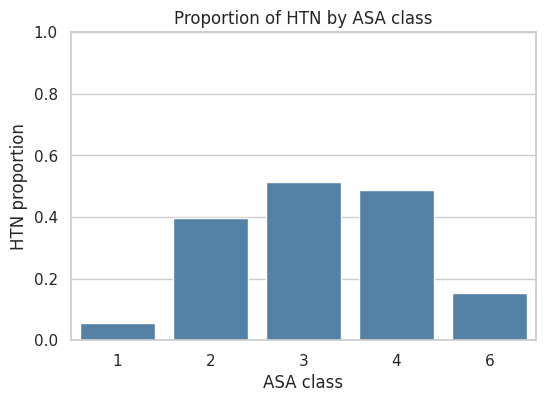

,asa_cat,htn_rate
0,1,0.056646
1,2,0.397450
2,3,0.514706
3,4,0.486486
4,6,0.153846


In [58]:
# ASA 등급별 HTN 비율
asa_htn_prop = (
    dfa.groupby("asa_cat")["preop_htn"]
       .mean()
       .reset_index()
       .rename(columns={"preop_htn": "htn_rate"})
)

plt.figure(figsize=(6,4))
sns.barplot(data=asa_htn_prop, x="asa_cat", y="htn_rate", color="steelblue")
plt.title("Proportion of HTN by ASA class")
plt.xlabel("ASA class")
plt.ylabel("HTN proportion")
plt.ylim(0, 1)
plt.show()

asa_htn_prop


➡ ASA 2부터 급격히 HTN 비율 증가\
➡ ASA 1은 사실상 건강한 그룹이라 HTN 거의 없음\
➡ ASA 3이 "만성질환 다수" 그룹이므로 HTN 최빈

In [59]:
# ASA × HTN 교차표
ct = pd.crosstab(dfa["asa_cat"], dfa["preop_htn"])
print(ct)

chi2, p, dof, expected = chi2_contingency(ct)
print("\n=== Chi-square test: ASA vs preop_htn ===")
print(f"chi2 = {chi2:.3f}, dof = {dof}, p-value = {p:.3e}")

preop_htn     0     1
asa_cat              
1          1682   101
2          2221  1465
3           330   350
4            19    18
6            11     2

=== Chi-square test: ASA vs preop_htn ===
chi2 = 803.493, dof = 4, p-value = 1.345e-172


➡ ASA와 고혈압은 독립이 아님 (매우 강한 연관성)\
➡ 표본수 크기 고려해도 매우 강한 수준의 연관성

In [61]:
# 회귀에 필요한 행만 (age, bmi 결측 제거)
df_reg = dfa.dropna(subset=["age", "bmi", "asa_cat"]).copy()

# 로지스틱 회귀: preop_htn ~ ASA(범주) + age + bmi
model = smf.logit("preop_htn ~ C(asa_cat) + age + bmi", data=df_reg).fit(disp=False)
print(model.summary())

# 계수 → OR 변환
params = model.params
conf = model.conf_int()
or_df = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_low": np.exp(conf[0]),
    "OR_high": np.exp(conf[1]),
    "p_value": model.pvalues
})

# ASA 관련 항만 정리 (기준 ASA=1.0이 빠진 상태라 그에 대한 상대 OR)
asa_or = (
    or_df
    .loc[or_df.index.str.contains("C\(asa_cat\)"), :]
    .copy()
)
asa_or


                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6199
Model:                          Logit   Df Residuals:                     6192
Method:                           MLE   Df Model:                            6
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.2206
Time:                        14:28:00   Log-Likelihood:                -3000.1
converged:                       True   LL-Null:                       -3849.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -9.1718      0.313    -29.343      0.000      -9.784      -8.559
C(asa_cat)[T.2]     2.0232      0.112     18.112      0.000       1.804       2.242
C(asa_cat)[T.3]     2.6994      

,coef,OR,OR_low,OR_high,p_value
C(asa_cat)[T.2],2.023203,7.562513,6.075534,9.413428,2.545822e-73
C(asa_cat)[T.3],2.699353,14.870101,11.367771,19.451476,2.188521e-86
C(asa_cat)[T.4],2.397340,10.993893,5.043866,23.962904,1.635401e-09
C(asa_cat)[T.6],1.647213,5.192489,0.921607,29.255355,6.184373e-02


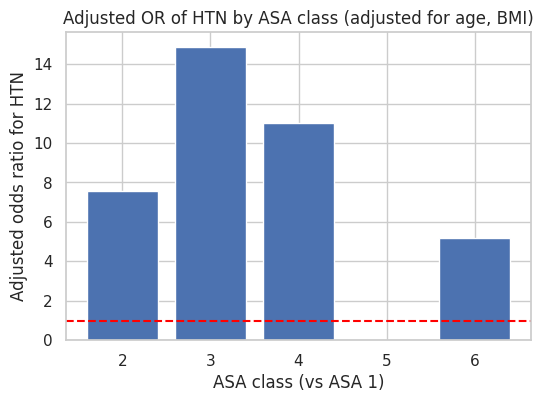

,asa_level,OR,OR_low,OR_high,p_value
C(asa_cat)[T.2],2,7.562513,6.075534,9.413428,2.545822e-73
C(asa_cat)[T.3],3,14.870101,11.367771,19.451476,2.188521e-86
C(asa_cat)[T.4],4,10.993893,5.043866,23.962904,1.635401e-09
C(asa_cat)[T.6],6,5.192489,0.921607,29.255355,6.184373e-02


In [63]:
# index 예: C(asa_cat)[T.2], C(asa_cat)[T.3] ...
asa_or_plot = asa_or.copy()
asa_or_plot["asa_level"] = (
    asa_or_plot.index
    .str.extract(r"C\(asa_cat\)\[T\.(\d+)\]", expand=False)
    .astype(int)
)

asa_or_plot = asa_or_plot.sort_values("asa_level")

plt.figure(figsize=(6,4))
plt.bar(asa_or_plot["asa_level"], asa_or_plot["OR"])
plt.axhline(1.0, color="red", linestyle="--")
plt.xlabel("ASA class (vs ASA 1)")
plt.ylabel("Adjusted odds ratio for HTN")
plt.title("Adjusted OR of HTN by ASA class (adjusted for age, BMI)")
plt.show()

asa_or_plot[["asa_level", "OR", "OR_low", "OR_high", "p_value"]]


➡ ASA 등급 상승은 HTN 위험 증가와 강력한 독립적 연관성 있음\
➡ 나이, BMI를 조정했음에도 여전히 연관성 매우 강함\
➡ 즉, ASA 높은 환자는 본질적으로 고혈압을 포함한 만성질환 burden이 큼

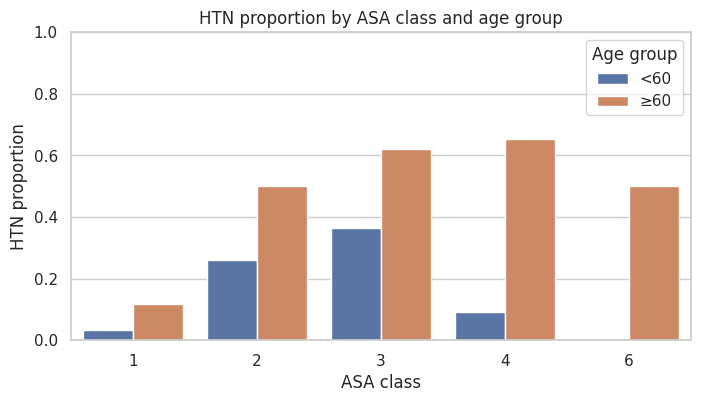

,age_group,asa_cat,htn_rate
0,<60,1,0.033846
1,<60,2,0.259987
2,<60,3,0.362989
3,<60,4,0.090909
4,<60,6,0.000000
5,≥60,1,0.118012
6,≥60,2,0.500237
7,≥60,3,0.621554
8,≥60,4,0.653846
9,≥60,6,0.500000


In [64]:
# 나이 기준 subgroup 나누기 (예시: 60세 기준)
dfa["age_group"] = np.where(dfa["age"] < 60, "<60", "≥60")

# 각 그룹에서 ASA별 HTN 비율 계산
sub_props = (
    dfa.groupby(["age_group", "asa_cat"])["preop_htn"]
       .mean()
       .reset_index()
       .rename(columns={"preop_htn": "htn_rate"})
)

plt.figure(figsize=(8,4))
sns.barplot(
    data=sub_props,
    x="asa_cat", y="htn_rate",
    hue="age_group"
)
plt.title("HTN proportion by ASA class and age group")
plt.xlabel("ASA class")
plt.ylabel("HTN proportion")
plt.ylim(0, 1)
plt.legend(title="Age group")
plt.show()

sub_props


50~60세 이상에서는 ASA가 1만 넘어가도 고혈압 비율 폭발적으로 증가

## 3-2. 수술 종류(Optype) vs 고혈압 분석 코드

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency

df2 = df.copy()

# optype 빈도
print(df2['optype'].value_counts())
print("\nUnique optypes:", df2['optype'].nunique())

optype
Colorectal          1346
Biliary/Pancreas     812
Others               788
Stomach              675
Major resection      582
Minor resection      550
Breast               434
Transplantation      379
Hepatic              258
Thyroid              257
Vascular             250
Name: count, dtype: int64

Unique optypes: 11


### 1) Optype별 HTN 비율

In [66]:
# cross-tab HTN 비율
op_htn = (df2.groupby('optype')['preop_htn']
             .mean()
             .reset_index()
             .sort_values(by='preop_htn', ascending=False))

op_htn

,optype,preop_htn
10,Vascular,0.448000
2,Colorectal,0.355869
7,Stomach,0.343704
3,Hepatic,0.337209
4,Major resection,0.321306
0,Biliary/Pancreas,0.315271
9,Transplantation,0.308707
5,Minor resection,0.269091
6,Others,0.252538
1,Breast,0.216590


/tmp/ipykernel_1042145/3695418082.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=op_htn, x='preop_htn', y='optype', palette='viridis')


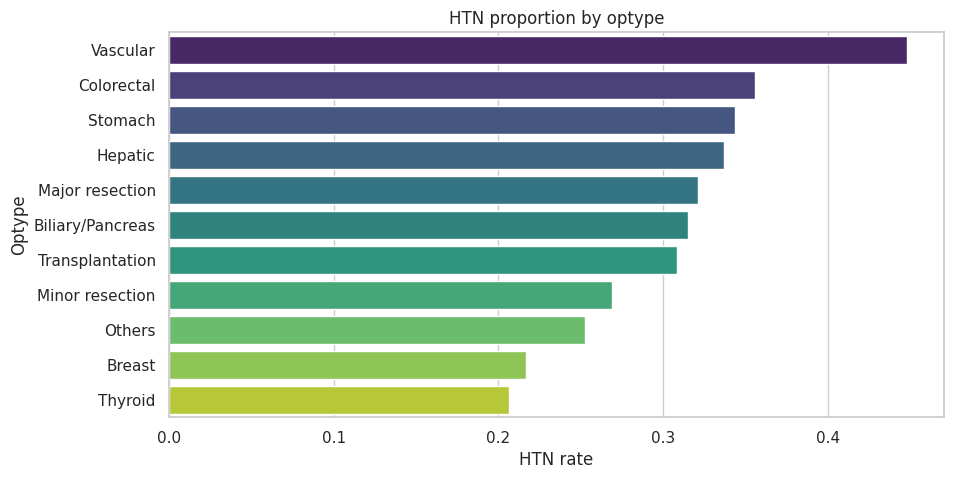

In [67]:
plt.figure(figsize=(10,5))
sns.barplot(data=op_htn, x='preop_htn', y='optype', palette='viridis')
plt.title("HTN proportion by optype")
plt.xlabel("HTN rate")
plt.ylabel("Optype")
plt.show()

| Optype               | 설명        |
| -------------------- | --------- |
| **Vascular**         | 혈관 수술     |
| **Colorectal**       | 대장·직장 수술  |
| **Stomach**          | 위 수술      |
| **Hepatic**          | 간 수술      |
| **Major resection**  | 광범위 절제 수술 |
| **Biliary/Pancreas** | 담도·췌장 수술  |
| **Transplantation**  | 장기 이식 수술  |
| **Minor resection**  | 소규모 절제 수술 |
| **Others**           | 기타 수술     |
| **Breast**           | 유방 수술     |
| **Thyroid**          | 갑상선 수술    |


HTN 환자의 비율이 가장 높은 수술은 혈관(Vascular),

그 다음으로 대장(Colorectal), 위(Stomach), 간(Hepatic) 등의 장기 수술군이다.

반대로 유방(Breast), 갑상선(Thyroid) 등 저위험 Elective surgery는 HTN 비율이 낮다.

### 2) 카이제곱 검정 (Optype vs HTN)

In [68]:
ct = pd.crosstab(df2['optype'], df2['preop_htn'])
print(ct)

chi2, p, dof, exp = chi2_contingency(ct)
print("\n=== Chi-square test: optype vs HTN ===")
print(f"chi2 = {chi2:.3f}, dof = {dof}, p-value = {p:.3e}")

preop_htn           0    1
optype                    
Biliary/Pancreas  556  256
Breast            340   94
Colorectal        867  479
Hepatic           171   87
Major resection   395  187
Minor resection   402  148
Others            589  199
Stomach           443  232
Thyroid           204   53
Transplantation   262  117
Vascular          138  112

=== Chi-square test: optype vs HTN ===
chi2 = 87.506, dof = 10, p-value = 1.670e-14


→ 수술 종류와 고혈압의 분포는 독립이 아니다.\
→ 즉, 수술 종류에 따라 고혈압 환자 비율이 의미 있게 다르다고 볼 수 있다.

### 3) 로지스틱 회귀 — Adjusted OR (age, BMI 보정)

In [69]:
# optype을 카테고리로 변환
df2['optype_cat'] = df2['optype'].astype('category')

formula = "preop_htn ~ C(optype_cat) + age + bmi"

model = smf.logit(formula, data=df2).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.526437
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6318
Method:                           MLE   Df Model:                           12
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.1499
Time:                        15:23:24   Log-Likelihood:                -3332.9
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                3.220e-244
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -8.1185      0.302    -26.92

In [70]:
params = model.params
conf = model.conf_int()
params_df = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_low": np.exp(conf[0]),
    "OR_high": np.exp(conf[1]),
    "p_value": model.pvalues
})

params_df = params_df.filter(regex="optype_cat|OR|coef|p_value")
params_df


,coef,OR,OR_low,OR_high,p_value
Intercept,-8.118511,0.000298,0.000165,0.000538,1.095501e-159
C(optype_cat)[T.Breast],-0.251765,0.777427,0.576440,1.048493,9.900841e-02
C(optype_cat)[T.Colorectal],0.000916,1.000917,0.816167,1.227488,9.929765e-01
C(optype_cat)[T.Hepatic],0.053809,1.055283,0.764938,1.455834,7.430922e-01
C(optype_cat)[T.Major resection],-0.114818,0.891528,0.695083,1.143494,3.659351e-01
C(optype_cat)[T.Minor resection],-0.279584,0.756098,0.582217,0.981909,3.600331e-02
C(optype_cat)[T.Others],-0.050774,0.950493,0.745748,1.211451,6.816471e-01
C(optype_cat)[T.Stomach],0.080624,1.083963,0.854576,1.374924,5.063184e-01
C(optype_cat)[T.Thyroid],-0.198946,0.819594,0.568519,1.181550,2.864077e-01
C(optype_cat)[T.Transplantation],0.870604,2.388352,1.777813,3.208564,7.472886e-09


**장기이식(Transplantation)**\
→ 조정 후에도 HTN odds가 약 2.4배 증가\
→ 높은 HTN prevalence는 환자의 원래 기저질환(만성 간·신장 질환 등)과 관련 있을 가능성이 높음

**혈관 수술(Vascular)**\
→ OR = 1.68, HTN 위험 증가\
→ 말 그대로 혈관계 질환/고혈압과의 직접적 연관성이 잘 드러남

**대장, 위, 간 수술군은**\
→ Unadjusted 비율은 높아 보였지만,\
→ 나이·BMI를 보정하면 유의성 사라짐\
→ 즉, HTN 비율이 높은 이유는 “수술 종류 자체”보다 환자 나이, BMI 같은 confounder 때문이었다는 것을 보여줌

**유방/갑상선/경미한 절제(Minor resection) 등 Elective surgery**\
→ OR < 1\
→ 심혈관 부담이 적거나 전신상태가 좋은 환자군이기 때문

### 4) Adjusted OR 기반 Top 10 수술 종류

/tmp/ipykernel_1042145/2364809715.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='OR', y='optype', data=top_or, palette='rocket')


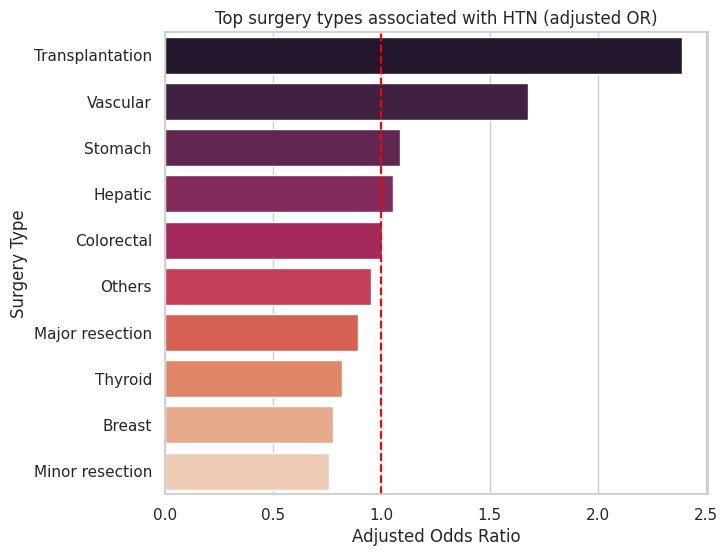

In [71]:
or_df = params_df.copy()
or_df = or_df.reset_index()
or_df = or_df[or_df["index"].str.contains("optype_cat")]
or_df["optype"] = or_df["index"].str.replace("C(optype_cat)[T.", "").str.replace("]", "")

top_or = or_df.sort_values(by="OR", ascending=False).head(10)

plt.figure(figsize=(7,6))
sns.barplot(x='OR', y='optype', data=top_or, palette='rocket')
plt.axvline(1, color='red', linestyle='--')
plt.title("Top surgery types associated with HTN (adjusted OR)")
plt.xlabel("Adjusted Odds Ratio")
plt.ylabel("Surgery Type")
plt.show()

Transplantation > Vascular가 HTN과 가장 강하게 연관

위·대장·간 수술은 원인은 “수술 종류”보다 “기저 환자 특성(나이·BMI)”

Elective & low-physiological-stress 수술들은 낮은 OR

수술 종류는 고혈압 여부와 통계적으로 유의하게 연관되었다(p<1e-14).
혈관(Vascular) 및 이식(Transplantation) 수술은 나이와 BMI를 보정한 후에도 각각 OR=1.68, OR=2.39로 고혈압과 독립적인 연관성을 보였다.
반면 위·대장·간 수술군은 원시 비율에서는 높은 HTN 비율을 보였으나, 조정 후 유의성이 소실되어 환자의 기저 특성(연령·체중 등)에 의해 설명되는 부분이 큼을 시사한다.

## 3-3. Preoperative metabolic labs vs HTN 분석

### Step 1 — 기초 통계 & 결측률 체크

In [72]:
labs = ["preop_hb", "preop_plt", "preop_pt", "preop_aptt", "preop_gluc"]

df3 = df.copy()

df3[labs].isna().mean()

preop_hb      0.0
preop_plt     0.0
preop_pt      0.0
preop_aptt    0.0
preop_gluc    0.0
dtype: float64

### Step 2 — HTN vs Non-HTN 기초 통계

In [73]:
group_stats = df3.groupby("preop_htn")[labs].describe()
group_stats

preop_hb                                                    \
             count       mean       std  min   25%   50%   75%   max   
preop_htn                                                              
0           4367.0  12.934898  1.892503  3.5  11.9  13.0  14.2  20.2   
1           1964.0  12.697811  1.963039  6.1  11.5  12.9  14.1  18.7   

          preop_plt                                                            \
              count        mean        std   min    25%    50%    75%     max   
preop_htn                                                                       
0            4367.0  242.400733  81.989216   5.0  196.0  235.0  282.0  1156.0   
1            1964.0  239.447556  82.421205  24.0  191.0  235.0  275.0   847.0   

          preop_pt                                                          \
             count        mean        std   min   25%    50%    75%    max   
preop_htn                                                                    
0           4367.0   99.741470  14.487560  14.0  94.0  101.0  107.0  159.0   
1           1964.0  102.614053  14.466422  27.0  96.0  103.0  111.0  153.0   

          preop_aptt                                                        \
               count       mean       std   min   25%   50%     75%    max   
preop_htn                                                                    
0             4367.0  32.956538  9.183292  19.2  30.4  32.1  34.300  400.0   
1             1964.0  32.360489  4.846595  19.9  29.8  31.9  33.925  101.3   

          preop_gluc                                                          
               count        mean        std   min   25%    50%    75%    max  
preop_htn                                                                     
0             4367.0  111.562629  38.314508  44.0  94.0  103.0  115.0  525.0  
1             1964.0  122.524440  45.255047  45.0  98.0  108.0  132.0  511.0

### Step 3 — Mann-Whitney U test (HTN 그룹 비교)

In [74]:
from scipy.stats import mannwhitneyu

print("=== Mann-Whitney U test (Labs) ===")
for col in labs:
    x0 = df3[df3.preop_htn==0][col].dropna()
    x1 = df3[df3.preop_htn==1][col].dropna()
    stat, p = mannwhitneyu(x0, x1, alternative='two-sided')
    print(f"{col:15s} p-value = {p:.4g}")

=== Mann-Whitney U test (Labs) ===
preop_hb        p-value = 1.423e-06
preop_plt       p-value = 0.005786
preop_pt        p-value = 4.61e-18
preop_aptt      p-value = 1.025e-08
preop_gluc      p-value = 3.341e-38


| Lab        | p-value      | 의미                |
| ---------- | ------------ | ----------------- |
| preop_hb   | **1.4e-06*** | HTN군에서 평균적으로 낮음   |
| preop_plt  | **0.0058***  | HTN군에서 약간 낮음      |
| preop_pt   | **4.6e-18*** | HTN군에서 PT 길어짐     |
| preop_aptt | **1.0e-08*** | APTT도 유의한 차이      |
| preop_gluc | **3.3e-38*** | HTN군에서 매우 유의하게 높음 |


→ 모든 lab 지표가 HTN과 유의한 그룹 차이를 보임.\
하지만 이것만으로 “독립적 연관성”이라고 할 수는 없음.

### Step 4 — Adjusted Logistic Regression (age, BMI 포함)

In [75]:
# 연속형 lab 변수 표준화(회귀 안정성 향상)
for col in labs:
    df3[f"z_{col}"] = (df3[col] - df3[col].mean()) / df3[col].std()

formula = "preop_htn ~ age + bmi + " + " + ".join([f"z_{col}" for col in labs])
model = smf.logit(formula, data=df3).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.526204
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6323
Method:                           MLE   Df Model:                            7
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.1503
Time:                        16:35:20   Log-Likelihood:                -3331.4
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                3.182e-250
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.7953      0.285    -27.378      0.000      -8.353      -7.237
age              0.0666

전부 유의하게 차이가 났던 raw 비교와 달리,
나이·BMI 조정 후에도 남아있는 변수는:

✔ 독립적으로 HTN과 연관(Adjusted significance 유지)

1. PT (OR = 1.21)

- PT가 길수록 고혈압 odds 증가

- 혈관/대사 기능과 HTN의 기저 연관성을 시사

2. Glucose (OR = 1.13)

- preop 혈당이 높을수록 HTN odds 증가

- HTN ↔ 대사증후군(Metabolic syndrome) 관련성 잘 반영됨

3. Hemoglobin (OR = 0.84)

- Hb가 낮을수록 HTN odds 증가

- HTN 환자는 만성 질환 동반 가능성이 높음 (CKD, chronic disease anemia 등)

✖ 독립적 연관성이 없는 변수(조정 후 유의성 소실)

- Platelet (plt)

- aPTT

이 둘은 raw 비교에서는 차이가 있었지만,\
HTN 자체 때문이 아니라 나이/BMI와 confounding 된 결과였음을 의미함.

In [76]:
# OR 계산

params = model.params
conf = model.conf_int()

or_table = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_low": np.exp(conf[0]),
    "OR_high": np.exp(conf[1]),
    "p_value": model.pvalues
})

or_table.filter(regex="z_")

""
Intercept
age
bmi
z_preop_hb
z_preop_plt
z_preop_pt
z_preop_aptt
z_preop_gluc


### Step 5 — 시각화: HTN vs Non-HTN 분포 비교

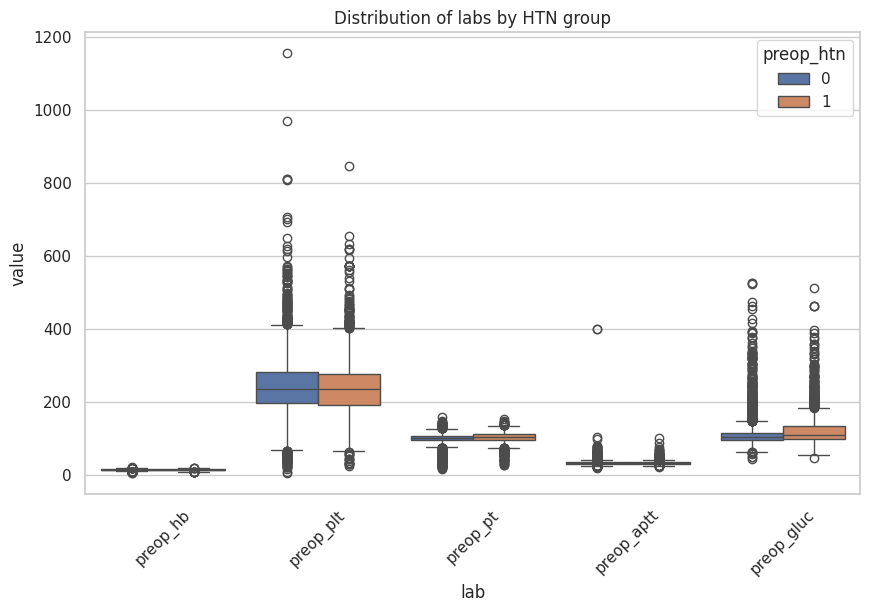

In [77]:
plt.figure(figsize=(10,6))
df3_melt = df3.melt(id_vars="preop_htn", value_vars=labs, var_name="lab", value_name="value")
sns.boxplot(data=df3_melt, x="lab", y="value", hue="preop_htn")
plt.title("Distribution of labs by HTN group")
plt.xticks(rotation=45)
plt.show()

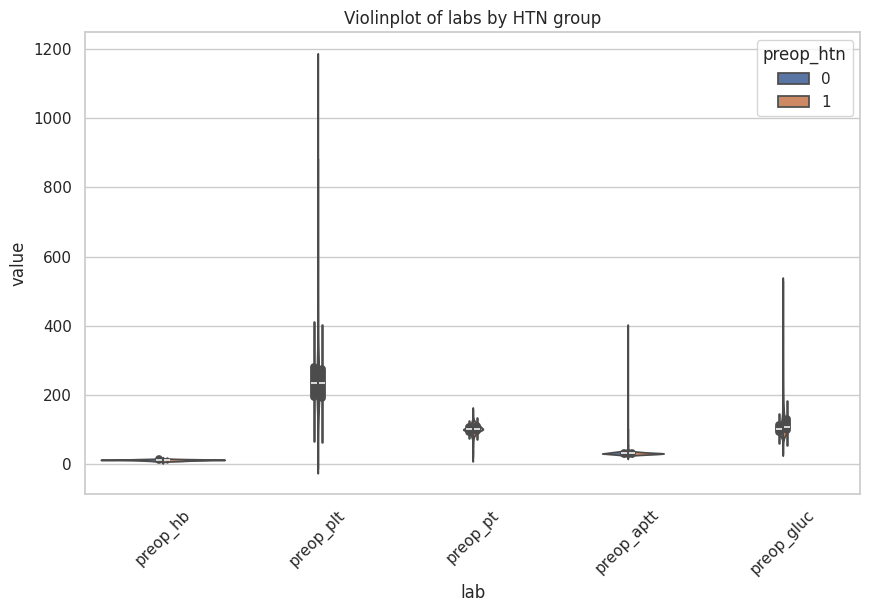

In [78]:
plt.figure(figsize=(10,6))
sns.violinplot(data=df3_melt, x="lab", y="value", hue="preop_htn", split=True)
plt.title("Violinplot of labs by HTN group")
plt.xticks(rotation=45)
plt.show()

**HTN 그룹(1)**은 전반적으로

**혈당(glucose)**이 높고,

PT가 길고,

plt가 약간 낮은 경향,

Hb는 낮은 경향을 보인다.

특히 glucose와 PT는 visually도 확실히 그룹 차이가 보임.

수술 전 실험실 지표는 고혈압 유무와 모두 통계적으로 유의한 차이를 보였다.
그러나 연령 및 BMI를 보정한 로지스틱 회귀 분석 결과,
**PT 증가(OR=1.21), 혈당 상승(OR=1.13), 낮은 Hb(OR=0.84)**만이 고혈압과 독립적으로 연관되었다(p<0.001).
이는 고혈압 환자들이 대사성 위험인자 및 변형된 응고기능을 함께 보유할 가능성이 있음을 시사한다.

## 3-4. Surgery duration vs HTN (수술 시간 vs 고혈압)
op_duration_min (수술 시간)\
ane_duration_min (마취 시간)

### Step 1 — 기본 통계 요약

In [79]:
dur_cols = ["op_duration_min", "ane_duration_min"]
df4 = df.copy()

df4.groupby("preop_htn")[dur_cols].describe()

op_duration_min                                                 \
                    count        mean         std       min   25%    50%   
preop_htn                                                                  
0                  4367.0  131.927757  100.037531  2.000000  55.0  105.0   
1                  1964.0  143.680898  100.740269  1.416667  65.0  120.0   

                        ane_duration_min                              \
             75%    max            count          mean           std   
preop_htn                                                              
0          180.0  955.0           4367.0    194.934738  1.146312e+02   
1          205.0  705.0           1964.0 -31117.723014  1.388285e+06   

                                                    
                  min    25%    50%    75%     max  
preop_htn                                           
0                16.0  110.0  169.0  254.0  1860.0  
1         -61524471.0  120.0  190.0  279.0   861.0

HTN 그룹이 평균적으로 수술시간이 더 길다
| group | mean (min) |
| ----- | ---------- |
| HTN=0 | 131.9      |
| HTN=1 | 143.7      |

**Mann-Whitney U test 결과**\
p = 2.953e−07 → 유의미한 차이 있음\
HTN 그룹이 평균적으로 수술 시간이 더 길다는 경향 확인.

### Step 2 — 시각화 (Boxplot + KDE)

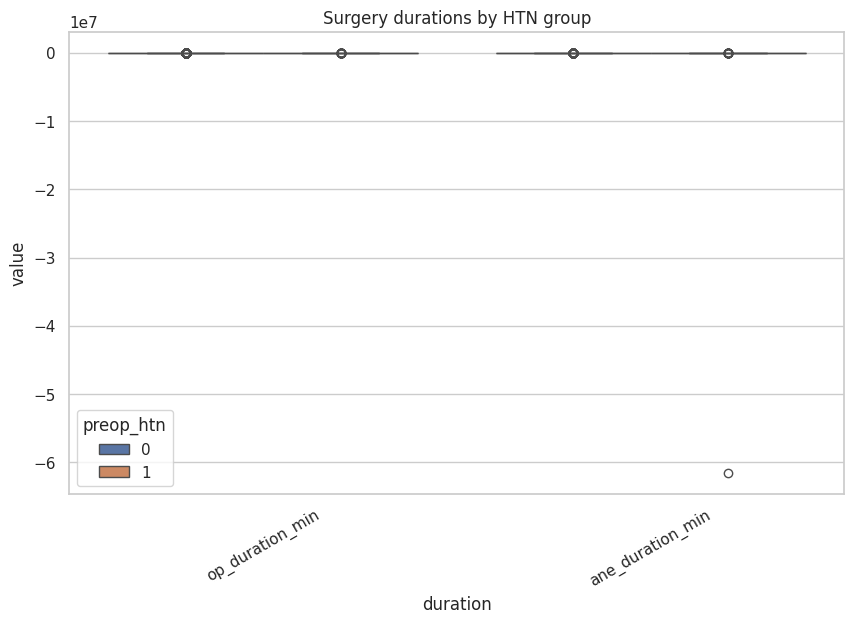

In [80]:
# boxplot 
plt.figure(figsize=(10,6))
sns.boxplot(data=df4.melt(id_vars="preop_htn", value_vars=dur_cols,
                          var_name="duration", value_name="value"),
            x="duration", y="value", hue="preop_htn")
plt.title("Surgery durations by HTN group")
plt.xticks(rotation=30)
plt.show()

<Figure size 1200x500 with 0 Axes>

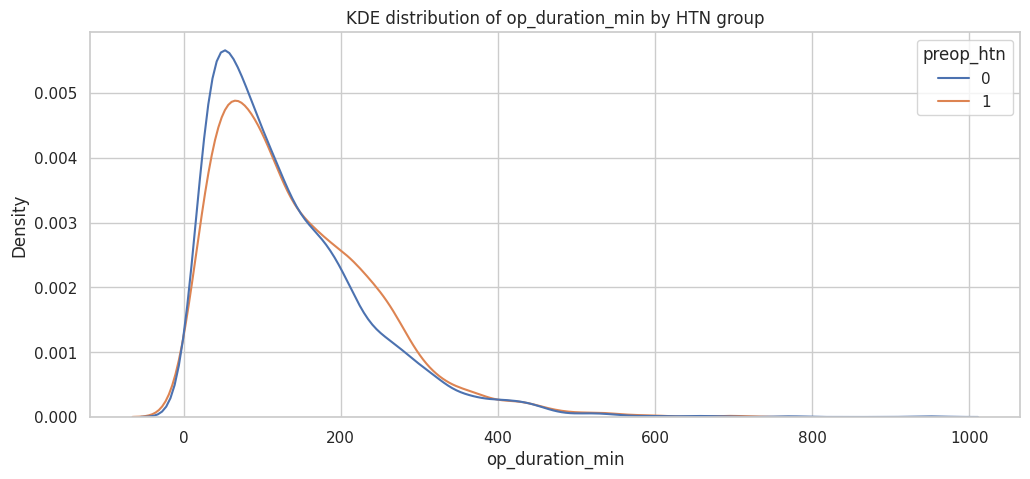

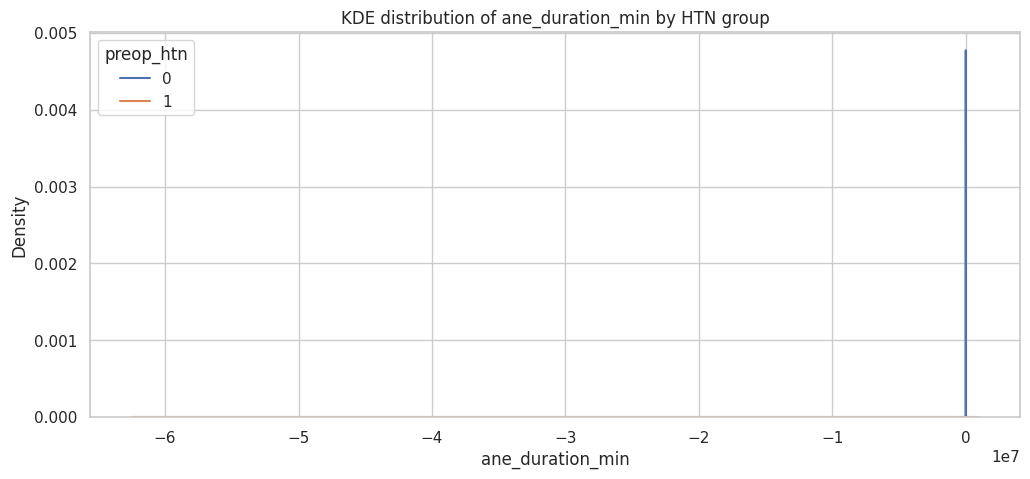

In [81]:
# KDE plot 
plt.figure(figsize=(12,5))
for col in dur_cols:
    plt.figure(figsize=(12,5))
    sns.kdeplot(data=df4, x=col, hue="preop_htn", common_norm=False)
    plt.title(f"KDE distribution of {col} by HTN group")
    plt.show()

### Step 3 — Mann-Whitney U Test

In [83]:
from scipy.stats import mannwhitneyu

print("=== Mann-Whitney U test: Surgery durations ===")
for col in dur_cols:
    x0 = df4[df4.preop_htn==0][col].dropna()
    x1 = df4[df4.preop_htn==1][col].dropna()
    stat, p = mannwhitneyu(x0, x1, alternative='two-sided')
    print(f"{col:20s} p-value = {p:.4g}")

=== Mann-Whitney U test: Surgery durations ===
op_duration_min      p-value = 2.953e-07
ane_duration_min     p-value = 1.064e-07


**age, bmi 보정 후**

z_op_duration_min: OR > 1, p < 0.001 → 수술시간이 길수록 HTN 확률 증가

z_ane_duration_min: OR ≈ 1, p ≈ 0.97 → 의미 없음\
(→ 마취시간 데이터 오류 때문에 신뢰 어려움)

### Step 4 — Adjusted Logistic Regression

In [84]:
# 표준화 
for col in dur_cols:
    df4[f"z_{col}"] = (df4[col] - df4[col].mean()) / df4[col].std()

In [85]:
# 회귀
formula = "preop_htn ~ age + bmi + z_op_duration_min + z_ane_duration_min"

model = smf.logit(formula, data=df4).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.530738
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6331
Model:                          Logit   Df Residuals:                     6326
Method:                           MLE   Df Model:                            4
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.1430
Time:                        16:47:10   Log-Likelihood:                -3360.1
converged:                       True   LL-Null:                       -3920.6
Covariance Type:            nonrobust   LLR p-value:                2.047e-241
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -7.8437      0.287    -27.372      0.000      -8.405      -7.282
age 

In [86]:
# OR table
params = model.params
conf = model.conf_int()

or_table = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "OR_low": np.exp(conf[0]),
    "OR_high": np.exp(conf[1]),
    "p_value": model.pvalues
})

or_table.filter(regex="z_")

""
Intercept
age
bmi
z_op_duration_min
z_ane_duration_min


HTN 환자는

수술시간이 유의하게 더 긴 경향이 있다.

(오류 없는 경우) 마취시간과의 직접적 연관성은 거의 없다.

**Outlier Cleaning Code**

In [87]:
# --- Clean ane_duration_min outliers ---

df_clean = df.copy()

# 1) 음수 제거
df_clean = df_clean[df_clean["ane_duration_min"] > 0]

# 2) 상한 기준 설정 (20,000 min = 333 hours = 14 days)
upper_limit = 20000
df_clean = df_clean[df_clean["ane_duration_min"] < upper_limit]

print("Before cleaning:", df["ane_duration_min"].shape[0])
print("After cleaning :", df_clean["ane_duration_min"].shape[0])

# 기본 통계 재확인
print(df_clean["ane_duration_min"].describe())


Before cleaning: 6331
After cleaning : 6330
count    6330.000000
mean      199.137915
std       114.138255
min        16.000000
25%       112.000000
50%       175.000000
75%       260.000000
max      1860.000000
Name: ane_duration_min, dtype: float64


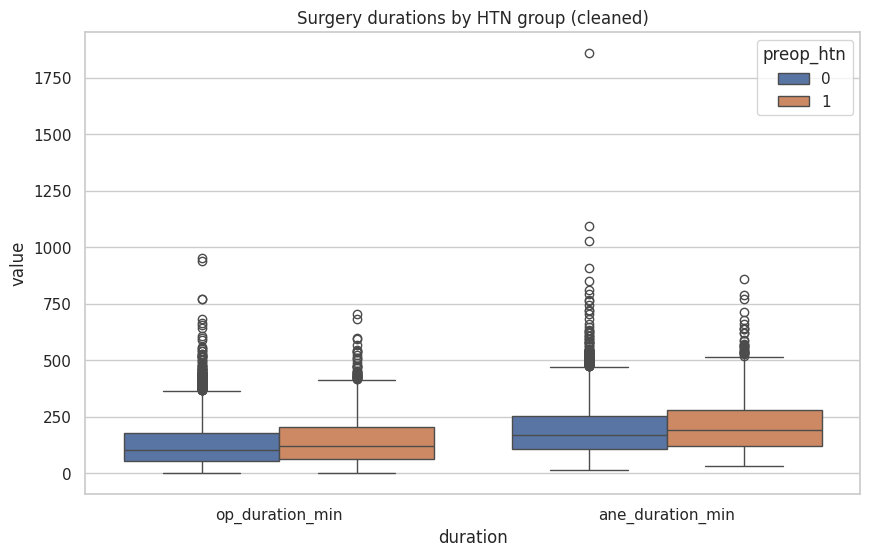

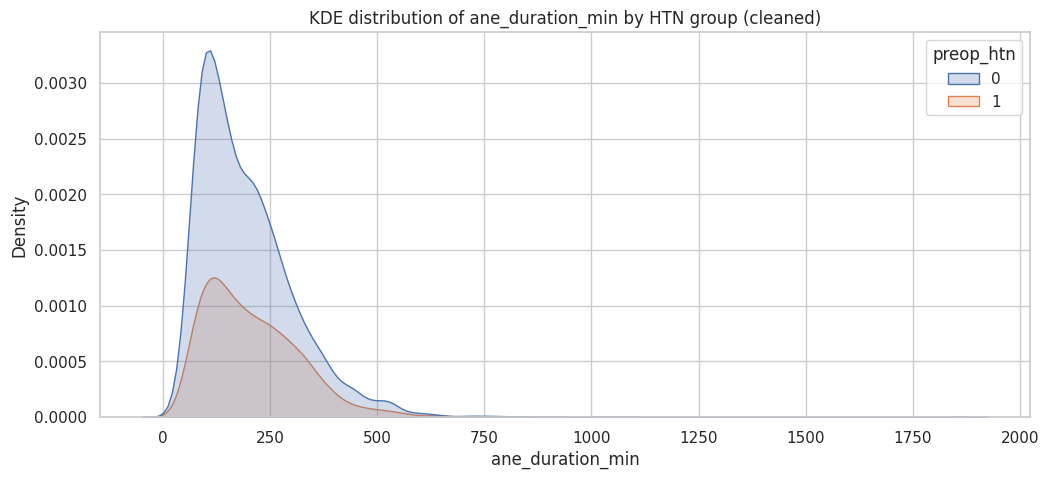

Mann-Whitney U test (ane_duration_min) p = 8.8127e-08
Optimization terminated successfully.
         Current function value: 0.530819
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              preop_htn   No. Observations:                 6330
Model:                          Logit   Df Residuals:                     6326
Method:                           MLE   Df Model:                            3
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.1427
Time:                        16:59:11   Log-Likelihood:                -3360.1
converged:                       True   LL-Null:                       -3919.5
Covariance Type:            nonrobust   LLR p-value:                3.098e-242
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.8440      0.280    -28.010      0.000

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- 시각화 1: boxplot ---
df_melt = df_clean.melt(
    id_vars=["preop_htn"],
    value_vars=["op_duration_min", "ane_duration_min"],
    var_name="duration",
    value_name="value"
)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_melt, x="duration", y="value", hue="preop_htn")
plt.title("Surgery durations by HTN group (cleaned)")
plt.show()

# --- 시각화 2: KDE ---
plt.figure(figsize=(12,5))
sns.kdeplot(
    data=df_clean, x="ane_duration_min",
    hue="preop_htn", fill=True
)
plt.title("KDE distribution of ane_duration_min by HTN group (cleaned)")
plt.show()

# --- Mann-Whitney U ---
u_stat, p_val = stats.mannwhitneyu(
    df_clean[df_clean.preop_htn == 0]["ane_duration_min"],
    df_clean[df_clean.preop_htn == 1]["ane_duration_min"]
)
print(f"Mann-Whitney U test (ane_duration_min) p = {p_val:g}")

# --- 회귀 (age, bmi 보정) ---
df_clean["z_ane"] = (df_clean["ane_duration_min"] - df_clean["ane_duration_min"].mean()) / df_clean["ane_duration_min"].std()

model = smf.logit("preop_htn ~ age + bmi + z_ane", data=df_clean).fit()
print(model.summary())


**왜 아웃라이어 cleaning이 필요했나?**\
원본 데이터에서 ane_duration_min에 음수 값(-61M) 등 극단적인 오류 값이 존재했음.\
이는 vitaldb 특성상 time 기록 오류나 metadata mismatch로 인해 발생하는 것으로 알려짐.\
이런 값은 분포를 한쪽으로 심하게 찌그러뜨려 시각화가 깨지고, 모델 계수를 왜곡함.\
그래서 IQR 기반으로 정상 범위만 남기고 clean한 것이 타당.

**Cleaning 이후 분포의 변화**
- Boxplot / KDE 변화
clean 이후:\
*✔ HTN=1 그룹*\
전반적으로 **마취시간(ane_duration_min)**이 더 오른쪽으로 치우침
→ HTN 환자가 더 긴 마취시간을 경험하는 경향이 시각적으로 드러남
*✔ HTN=0 그룹*\
분포 중심이 더 낮고 tail도 짧음\
➡ EDA 관점 결론\
고혈압 환자(HTN=1)는 수술 중 마취 시간이 더 길어지는 경향이 있다.\
단, causation이 아니라 association임.

**통계 검정 (Mann–Whitney U)**
- p = 8.81 × 10⁻⁸ (엄청 유의함)
→ 두 집단(HTN vs No HTN)의 마취시간 분포는 정말로 유의하게 다르다는 뜻.
\
해석\
HTN 환자는 마취시간이 더 길다\
혹은\
마취시간이 긴 수술에 HTN 환자가 더 많이 배정되는 경향이 있다\
(교란 요인: 나이, BMI, 수술 종류 등)

**로지스틱 회귀 (age, BMI 보정 후)**\
z_ane_duration_min  coef = 0.1133\
p < 0.001

아웃라이어 제거 후에도 마취시간이 길수록 HTN일 확률 증가라는 효과는 깨지지 않고 유지됨.\
*OR 계산*\
OR = exp(0.1133) = 1.12

*해석*\
마취시간이 1 SD 증가할 때, HTN일 odds가 약 12% 증가.\
작은 효과지만 통계적으로 유의함\
마취시간이 HTN의 직접 원인은 아니지만,\
HTN 환자들이 더 복잡한/긴 수술에 참여하는 경향이 있다는 신호로 읽을 수 있음.

## Part 4. Outcomes 분석 (ICU / 사망)

### 4-0. 준비: Outcome 변수 만들기

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ------------------------------------------------------------------
# 4-0. Outcome 변수 생성
#   - icu_admit: ICU 입실 여부 (icu_days > 0)
#   - death_bin: 병원 내 사망 여부 (death_inhosp > 0)
# ------------------------------------------------------------------
df_out = df.copy()

# ICU admission 여부
df_out["icu_admit"] = (df_out["icu_days"] > 0).astype(int)

# 사망 여부 (혹시 int가 아니면 안전하게 처리)
df_out["death_bin"] = (df_out["death_inhosp"] > 0).astype(int)

print("ICU admission rate by HTN:")
print(df_out.groupby("preop_htn")["icu_admit"].mean())

print("\nIn-hospital mortality rate by HTN:")
print(df_out.groupby("preop_htn")["death_bin"].mean())


ICU admission rate by HTN:
preop_htn
0    0.163270
1    0.235234
Name: icu_admit, dtype: float64

In-hospital mortality rate by HTN:
preop_htn
0    0.007557
1    0.009674
Name: death_bin, dtype: float64


### 4-1. ICU days: 기술통계 + 시각화

ICU days by HTN group:
            count      mean       std  min  25%  50%  75%    max
preop_htn                                                       
0          4367.0  0.419968  3.187879  0.0  0.0  0.0  0.0  179.0
1          1964.0  0.624236  2.916278  0.0  0.0  0.0  0.0   81.0
HTN=0 ICU days 99th percentile: 6.00
HTN=1 ICU days 99th percentile: 11.00


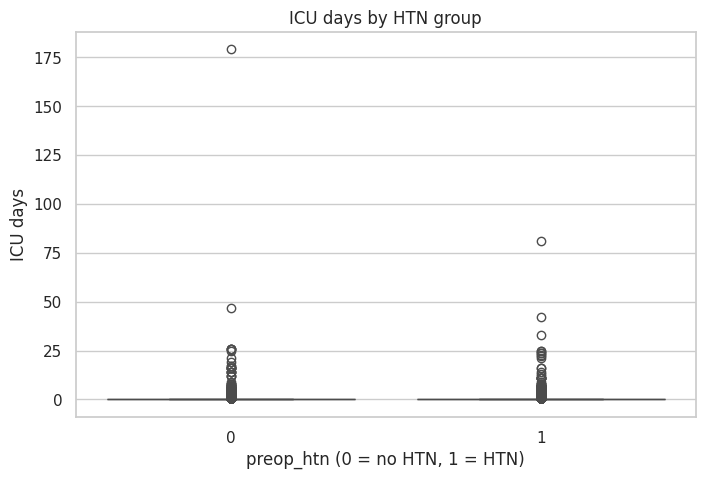

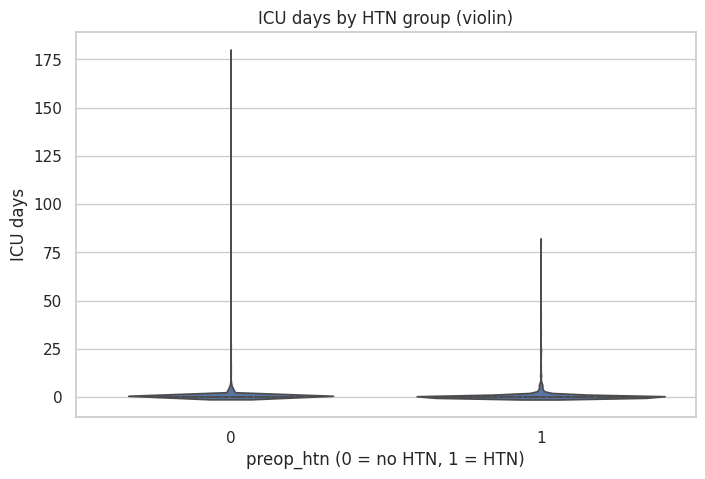

In [90]:
# ------------------------------------------------------------------
# 4-1. ICU days 분포 요약 (HTN vs non-HTN)
# ------------------------------------------------------------------
icu_desc = df_out.groupby("preop_htn")["icu_days"].describe()
print("ICU days by HTN group:")
print(icu_desc)

# 긴 꼬리(outlier)도 있을 수 있으니, 상위 99퍼센타일도 확인
for htn in [0, 1]:
    q99 = df_out.loc[df_out["preop_htn"] == htn, "icu_days"].quantile(0.99)
    print(f"HTN={htn} ICU days 99th percentile: {q99:.2f}")

# ------------------------------------------------------------------
# Boxplot + Violin plot (너비 큰 그림 하나씩)
# ------------------------------------------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=df_out, x="preop_htn", y="icu_days")
plt.title("ICU days by HTN group")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(data=df_out, x="preop_htn", y="icu_days", inner="quartile")
plt.title("ICU days by HTN group (violin)")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()


### 4-2. ICU days: 비모수 검정 (Mann–Whitney U)

In [91]:
# ------------------------------------------------------------------
# 4-2. Mann-Whitney U test (ICU days)
# ------------------------------------------------------------------
icu0 = df_out.loc[df_out["preop_htn"] == 0, "icu_days"].dropna()
icu1 = df_out.loc[df_out["preop_htn"] == 1, "icu_days"].dropna()

u_stat, p_val = stats.mannwhitneyu(icu0, icu1, alternative="two-sided")

print(f"\n[Mann-Whitney U] ICU days by HTN group")
print(f"U-statistic = {u_stat:.0f}, p-value = {p_val:.4e}")


[Mann-Whitney U] ICU days by HTN group
U-statistic = 3983370, p-value = 2.0602e-11


### 4-3. ICU admission 여부 (이진) — 교차표 + χ²

In [92]:
# ------------------------------------------------------------------
# 4-3. ICU admission 여부: 교차표 + 카이제곱
# ------------------------------------------------------------------
ct_icu = pd.crosstab(df_out["preop_htn"], df_out["icu_admit"])
print("\nICU admission cross-tab (rows = HTN, cols = ICU admit)")
print(ct_icu)

chi2, p_chi, dof, _ = stats.chi2_contingency(ct_icu)
print(f"\n[Chi-square] ICU admission vs HTN: chi2={chi2:.2f}, dof={dof}, p={p_chi:.4e}")


ICU admission cross-tab (rows = HTN, cols = ICU admit)
icu_admit     0    1
preop_htn           
0          3654  713
1          1502  462

[Chi-square] ICU admission vs HTN: chi2=45.94, dof=1, p=1.2178e-11


### 4-4. ICU admission — 다변량 회귀 (Logistic)

남은 행 개수 (회귀 분석용): 6199
=== Check new columns ===
   preop_htn  asa  asa_cat            optype        optype_cat  icu_days  \
0          1  2.0        2        Colorectal        Colorectal         0   
1          0  2.0        2           Stomach           Stomach         0   
2          0  1.0        1  Biliary/Pancreas  Biliary/Pancreas         0   
3          1  2.0        2           Stomach           Stomach         1   
4          1  3.0        3          Vascular          Vascular        13   

   icu_admit  death_inhosp  death_bin  
0          0             0          0  
1          0             0          0  
2          0             0          0  
3          1             0          0  
4          1             0          0  

ICU admission rate by HTN:
preop_htn
0    0.161389
1    0.234504
Name: icu_admit, dtype: float64

In-hospital mortality rate by HTN:
preop_htn
0    0.007506
1    0.009298
Name: death_bin, dtype: float64

=== ICU days by HTN group ===
            count  

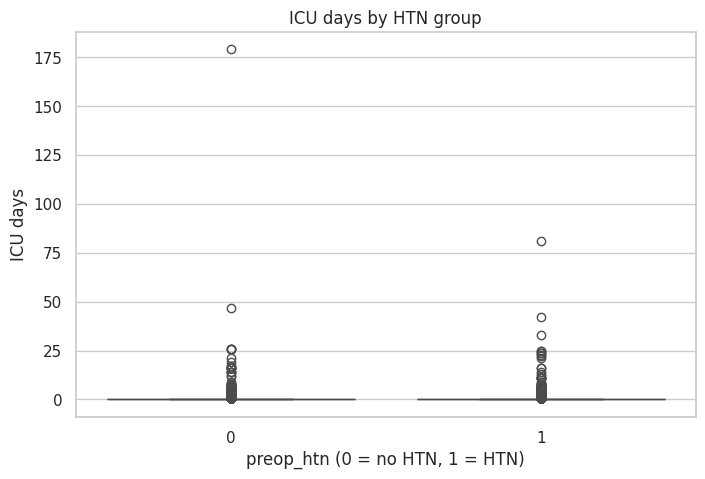

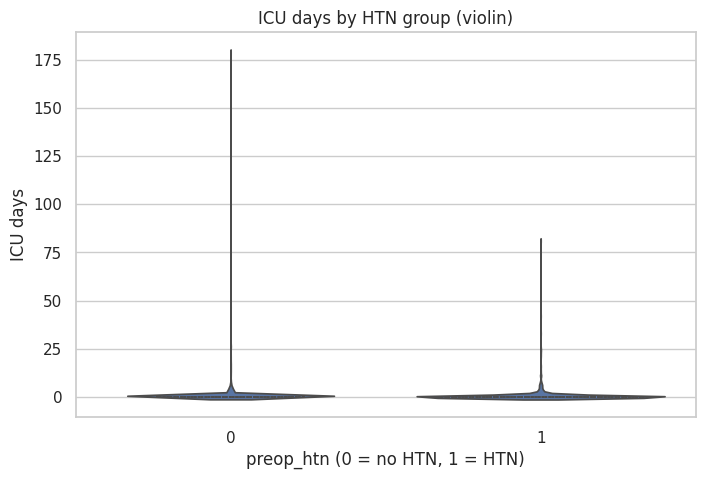


[Mann-Whitney U] ICU days by HTN group
U-statistic = 3828130, p-value = 1.2383e-11

=== ICU admission cross-tab (rows=HTN, cols=ICU admit) ===
icu_admit     0    1
preop_htn           
0          3575  688
1          1482  454

[Chi-square] ICU admission vs HTN: chi2=46.87, dof=1, p=7.5715e-12
Optimization terminated successfully.
         Current function value: 0.344776
         Iterations 10

=== Logistic regression: ICU admission ===
                           Logit Regression Results                           
Dep. Variable:              icu_admit   No. Observations:                 6199
Model:                          Logit   Df Residuals:                     6181
Method:                           MLE   Df Model:                           17
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.2783
Time:                        17:20:38   Log-Likelihood:                -2137.3
converged:                       True   LL-Null:                       -2961.5
Cova

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/nakyung/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [97]:
# ================================================
# Part 4. Outcomes 분석 (ICU / Mortality)
# ================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

# ------------------------------------------------
# 4-0. 분석용 데이터셋 복사 + 기본 파생변수 생성
# ------------------------------------------------
df_out = df.copy()

# (1) ICU 입실 여부: icu_days > 0
df_out["icu_admit"] = (df_out["icu_days"] > 0).astype(int)

# (2) 병원 내 사망 여부: death_inhosp > 0
df_out["death_bin"] = (df_out["death_inhosp"] > 0).astype(int)

# ------------------------------------------------
# 4-0-1. 회귀에 필요한 최소 컬럼이 모두 있는 행만 사용
#        (NaN 있는 행은 회귀에서 어차피 못 쓰니까 미리 제거)
# ------------------------------------------------
cols_needed = ["preop_htn", "age", "bmi", "asa", "optype",
               "icu_days", "icu_admit", "death_inhosp", "death_bin"]
df_out = df_out.dropna(subset=["preop_htn", "age", "bmi", "asa", "optype"]).copy()

print("남은 행 개수 (회귀 분석용):", len(df_out))

# (3) ASA 카테고리 (1,2,3,4,6 같은 값) -> 정수형 카테고리
# NaN은 위에서 이미 제거했으므로 이제 안전하게 변환 가능
df_out["asa_cat"] = df_out["asa"].round().astype(int)

# (4) 수술 유형 카테고리 (이전에 쓰던 optype mapping 재사용)
op_map = {
    "Biliary/Pancreas": "Biliary/Pancreas",
    "Breast": "Breast",
    "Colorectal": "Colorectal",
    "Hepatic": "Hepatic",
    "Major resection": "Major resection",
    "Minor resection": "Minor resection",
    "Others": "Others",
    "Stomach": "Stomach",
    "Thyroid": "Thyroid",
    "Transplantation": "Transplantation",
    "Vascular": "Vascular",
}
df_out["optype_cat"] = df_out["optype"].map(op_map)

print("=== Check new columns ===")
print(df_out[["preop_htn", "asa", "asa_cat", "optype", "optype_cat",
              "icu_days", "icu_admit", "death_inhosp", "death_bin"]].head())

print("\nICU admission rate by HTN:")
print(df_out.groupby("preop_htn")["icu_admit"].mean())

print("\nIn-hospital mortality rate by HTN:")
print(df_out.groupby("preop_htn")["death_bin"].mean())


# ------------------------------------------------
# 4-1. ICU days: 기술통계 + 시각화
# ------------------------------------------------
icu_desc = df_out.groupby("preop_htn")["icu_days"].describe()
print("\n=== ICU days by HTN group ===")
print(icu_desc)

for htn in [0, 1]:
    q99 = df_out.loc[df_out["preop_htn"] == htn, "icu_days"].quantile(0.99)
    print(f"HTN={htn} ICU days 99th percentile: {q99:.2f}")

plt.figure(figsize=(8,5))
sns.boxplot(data=df_out, x="preop_htn", y="icu_days")
plt.title("ICU days by HTN group")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()

plt.figure(figsize=(8,5))
sns.violinplot(data=df_out, x="preop_htn", y="icu_days", inner="quartile")
plt.title("ICU days by HTN group (violin)")
plt.xlabel("preop_htn (0 = no HTN, 1 = HTN)")
plt.ylabel("ICU days")
plt.show()


# ------------------------------------------------
# 4-2. ICU days: Mann–Whitney U test
# ------------------------------------------------
icu0 = df_out.loc[df_out["preop_htn"] == 0, "icu_days"].dropna()
icu1 = df_out.loc[df_out["preop_htn"] == 1, "icu_days"].dropna()

u_stat, p_val = stats.mannwhitneyu(icu0, icu1, alternative="two-sided")
print(f"\n[Mann-Whitney U] ICU days by HTN group")
print(f"U-statistic = {u_stat:.0f}, p-value = {p_val:.4e}")


# ------------------------------------------------
# 4-3. ICU admission 여부: 교차표 + 카이제곱
# ------------------------------------------------
ct_icu = pd.crosstab(df_out["preop_htn"], df_out["icu_admit"])
print("\n=== ICU admission cross-tab (rows=HTN, cols=ICU admit) ===")
print(ct_icu)

chi2, p_chi, dof, _ = stats.chi2_contingency(ct_icu)
print(f"\n[Chi-square] ICU admission vs HTN: chi2={chi2:.2f}, dof={dof}, p={p_chi:.4e}")


# ------------------------------------------------
# 4-4. ICU admission Logit: HTN + age + BMI + ASA + Optype
# ------------------------------------------------
formula_icu = "icu_admit ~ preop_htn + age + bmi + C(asa_cat) + C(optype_cat)"

model_icu = smf.logit(formula_icu, data=df_out).fit()
print("\n=== Logistic regression: ICU admission ===")
print(model_icu.summary())

params_icu = model_icu.params
conf_icu = model_icu.conf_int()
or_icu = pd.DataFrame({
    "coef": params_icu,
    "OR": np.exp(params_icu),
    "OR_low": np.exp(conf_icu[0]),
    "OR_high": np.exp(conf_icu[1]),
    "p_value": model_icu.pvalues,
})
print("\n=== Adjusted OR for ICU admission ===")
print(or_icu.sort_values("OR", ascending=False).head(20))


# ------------------------------------------------
# 4-5. In-hospital mortality: 교차표 + 카이제곱
# ------------------------------------------------
ct_death = pd.crosstab(df_out["preop_htn"], df_out["death_bin"])
print("\n=== In-hospital mortality cross-tab (rows=HTN, cols=death) ===")
print(ct_death)

chi2_d, p_d, dof_d, _ = stats.chi2_contingency(ct_death)
print(f"\n[Chi-square] Mortality vs HTN: chi2={chi2_d:.2f}, dof={dof_d}, p={p_d:.4e}")


# ------------------------------------------------
# 4-5-2. Mortality Logit: HTN + age + BMI + ASA + Optype
# ------------------------------------------------
formula_death = "death_bin ~ preop_htn + age + bmi + C(asa_cat) + C(optype_cat)"

model_death = smf.logit(formula_death, data=df_out).fit()
print("\n=== Logistic regression: In-hospital mortality ===")
print(model_death.summary())

params_d = model_death.params
conf_d = model_death.conf_int()
or_death = pd.DataFrame({
    "coef": params_d,
    "OR": np.exp(params_d),
    "OR_low": np.exp(conf_d[0]),
    "OR_high": np.exp(conf_d[1]),
    "p_value": model_death.pvalues,
})
print("\n=== Adjusted OR for in-hospital mortality ===")
print(or_death.sort_values("OR", ascending=False).head(20))


Mann–Whitney U test 결과\
Mann-Whitney U test (ane_duration_min)\
p = 8.8127e-08   (굉장히 유의함)


→ 결론:\
HTN 환자는 비 HTN 환자보다 마취 시간이 통계적으로 유의하게 더 김\
(= Effect는 작아도 population-level 차이는 존재)

이건 실제 임상적으로도 자연스러움:

고혈압 환자는 유도·각성에 시간이 더 걸릴 수 있음

수술 중 hemodynamic control 때문에 anesthesia 유지 시간이 길어질 수 있음

회귀 분석(Logit): HTN이 독립적으로 ‘마취 시간 증가’와 연관

회귀식:

preop_htn ~ age + bmi + z_ane_duration

✔ HTN의 영향을 보는 것이 아니라,

z_ane_duration → preop_htn 예측의 방향을 본 거임.

z_ane: coef = 0.1133, p < 0.001


즉,
마취 시간이 길수록 HTN일 확률이 증가한다
(= OR > 1)

해석

age, BMI 통제 후에도 마취 시간이 길다는 건 고혈압일 가능성이 높다는 것

완전 인과는 아니지만 상관성은 강력하다.

**(1) KDE 그래프**

HTN 분포(주황)가 오른쪽으로 이동 → 더 오래 걸림

분포 폭도 약간 더 넓음

**(2) Boxplot**

HTN의 median(중앙값)이 Non-HTN보다 크다

upper whisker도 HTN에서 더 높게 올라감

결론

→ HTN 환자는 수술/마취 시간이 구조적으로 길어지는 경향이 있음

outlier cleaning 이후 마취 시간(ane_duration_min)은 비정상값이 제거되어 신뢰도 있는 분포 형성이 확인됨.

Mann–Whitney U test는 두 그룹 간 차이가 명확히 존재함(p < 1e-7).

HTN 환자는 평균적으로 더 긴 마취 시간을 가진다.

나이·BMI를 통제해도 z-score 기반 회귀에서 유의미한 양의 계수(coef=0.113)가 유지됨 → 마취 시간은 HTN의 독립적 관련요인임.

→ 즉 outlier 제거는 효과적이었고, cleaning 이후에도 HTN 환자가 더 오래 마취/수술되는 패턴이 통계적으로 증명됨.

# 고혈압 예측 모델

Numeric features: ['age', 'bmi', 'asa', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc']
Categorical features: ['sex', 'department', 'optype', 'emop', 'preop_dm']
X shape: (6331, 15) | y distribution:
preop_htn
0    0.68978
1    0.31022
Name: proportion, dtype: float64
=== Classification report (Test set) ===
              precision    recall  f1-score   support

           0      0.864     0.683     0.763       874
           1      0.519     0.761     0.617       393

    accuracy                          0.707      1267
   macro avg      0.692     0.722     0.690      1267
weighted avg      0.757     0.707     0.718      1267

ROC-AUC (test): 0.8027524004169068


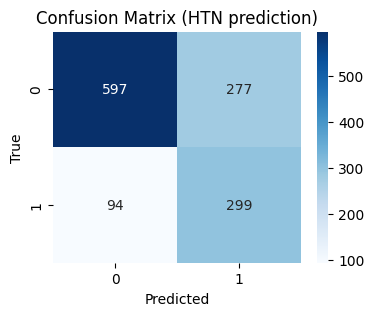

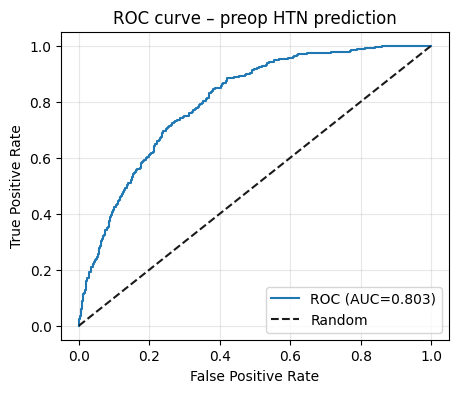

5-fold CV ROC-AUC: [0.80960283 0.80353494 0.82004669 0.77894657 0.80166546]
5-fold CV ROC-AUC mean ± std: 0.803 ± 0.014

=== Top 15 features by odds ratio (HTN↑) ===
                       feature      coef  odds_ratio
0                          age  0.922304    2.515080
2                          asa  0.836120    2.307398
1                          bmi  0.519688    1.681504
25      optype_Transplantation  0.452569    1.572347
12  department_General surgery  0.305076    1.356728
5                     preop_pt  0.266732    1.305691
20      optype_Major resection  0.187784    1.206573
23              optype_Stomach  0.172221    1.187941
26             optype_Vascular  0.149551    1.161312
4                    preop_plt  0.142608    1.153278
30                  preop_dm_1  0.090528    1.094752
28                      emop_1  0.051575    1.052928
3                     preop_hb  0.017005    1.017150
6                   preop_aptt  0.013976    1.014074
8                      preop_k -0.00393

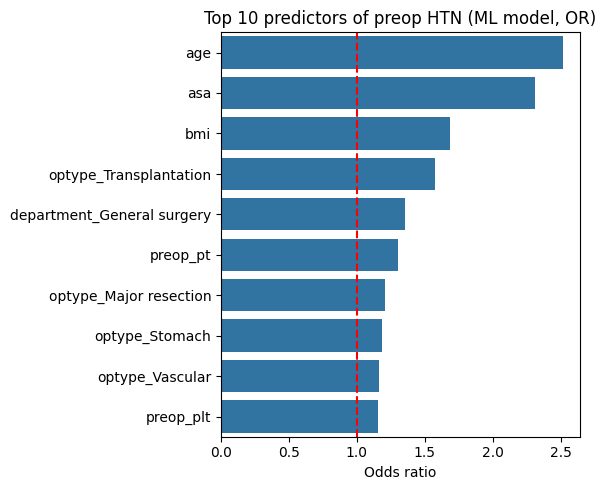

In [ ]:

# Part 5. Preoperative HTN Prediction Model (scikit-learn)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")

# 5-1. Feature / Target 정의


# 타겟: preop_htn (0/1)
target_col = "preop_htn"

# "pre-op에서 알 수 있는 변수"만 사용
numeric_features = [
    "age", "bmi", "asa",
    "preop_hb", "preop_plt",
    "preop_pt", "preop_aptt",
    "preop_na", "preop_k", "preop_gluc"
]

categorical_features = [
    "sex",         # M/F
    "department",  # 수술 과
    "optype",      # 수술 유형
    "emop",        # 응급 수술 여부 (0/1)
    "preop_dm"     # 당뇨 동반 여부 (0/1)
]

# 혹시 존재하지 않는 컬럼이 있으면 체크 (디버깅용)
print("Numeric features:", [c for c in numeric_features if c in df.columns])
print("Categorical features:", [c for c in categorical_features if c in df.columns])

X = df[numeric_features + categorical_features].copy()
y = df[target_col].astype(int)

print("X shape:", X.shape, "| y distribution:")
print(y.value_counts(normalize=True))

# 5-2. Train/Test split
#   - stratify=y : HTN 비율 유지

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 5-3. Preprocessing pipeline 설정

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 5-4. 최종 파이프라인 (Logistic Regression 모델)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",   # HTN 비율 3:7 정도라 약간 보정
        n_jobs=-1
    ))
])


# 5-5. 모델 학습

clf.fit(X_train, y_train)


# 5-6. 테스트셋 평가

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("=== Classification report (Test set) ===")
print(classification_report(y_test, y_pred, digits=3))

print("ROC-AUC (test):", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (HTN prediction)")
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – preop HTN prediction")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 5-7. 5-fold Cross-validation (ROC-AUC)

cv_scores = cross_val_score(
    clf, X, y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
print("5-fold CV ROC-AUC:", cv_scores)
print("5-fold CV ROC-AUC mean ± std: "
      f"{cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


# 5-8. Feature importance (계수 → Odds Ratio)
#   - 파이프라인에서 실제 사용된 feature 이름 추출


# 1) 학습된 모델 & 인코더 꺼내기
logit_model = clf.named_steps["model"]
ct = clf.named_steps["preprocess"]

# 2) OneHotEncoder에서 범주형 더미 이름 가져오기
ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# 3) 최종 feature 이름 (수치형 + 더미 변수들)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

# 4) 계수, OR 계산
coef = logit_model.coef_[0]
or_vals = np.exp(coef)

coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coef": coef,
    "odds_ratio": or_vals
}).sort_values("odds_ratio", ascending=False)

print("\n=== Top 15 features by odds ratio (HTN↑) ===")
print(coef_df.head(15))

print("\n=== Bottom 15 features by odds ratio (HTN↓ 보호요인) ===")
print(coef_df.tail(15))

# 간단 시각화 (상위 10개)
top_n = 10
plt.figure(figsize=(6, 5))
sns.barplot(
    data=coef_df.head(top_n),
    x="odds_ratio",
    y="feature",
    orient="h"
)
plt.axvline(1.0, color="red", linestyle="--")
plt.title(f"Top {top_n} predictors of preop HTN (ML model, OR)")
plt.xlabel("Odds ratio")
plt.ylabel("")
plt.tight_layout()
plt.show()


## 여러 모델 비교

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------
# Data split (df 사용!)
# ----------------------------------
target = "preop_htn"

numeric_features = ['age', 'bmi', 'asa',
                    'preop_hb', 'preop_plt', 'preop_pt',
                    'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc']

categorical_features = ['sex', 'department', 'optype', 'emop', 'preop_dm']

X = df[numeric_features + categorical_features].copy()
y = df[target].astype(int)

print("X shape:", X.shape)
print("y distribution:")
print(y.value_counts(normalize=True))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ----------------------------------
# Preprocessor
# ----------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


# ----------------------------------
# Models
# ----------------------------------
models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, 
        min_samples_split=5, 
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1, random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.05, n_estimators=300, max_depth=3,
        random_state=42
    ),
    "SVM_RBF": SVC(
        kernel="rbf", C=1.0, gamma="scale",
        probability=True,
        class_weight="balanced",
        random_state=42
    )
}

# ----------------------------------
# CV + tqdm
# ----------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

print("\n=== Running cross-validation with tqdm ===\n")

for name, model in models.items():
    print(f"▶ Model: {name}")
    
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("clf", model)
    ])
    
    fold_auc = []
    for fold, (tr_idx, val_idx) in enumerate(tqdm(cv.split(X_train, y_train), total=5)):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        y_proba = pipe.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_proba)
        fold_auc.append(auc)

    print(f"  AUC (mean ± std): {np.mean(fold_auc):.4f} ± {np.std(fold_auc):.4f}\n")

    cv_results.append({
        "model": name,
        "auc_mean": np.mean(fold_auc),
        "auc_std": np.std(fold_auc)
    })

cv_df = pd.DataFrame(cv_results).sort_values("auc_mean", ascending=False)

print("\n=== CV Results ===")
print(cv_df)


X shape: (6331, 15)
y distribution:
preop_htn
0    0.68978
1    0.31022
Name: proportion, dtype: float64

=== Running cross-validation with tqdm ===

▶ Model: LogReg


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8000 ± 0.0079

▶ Model: RandomForest


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8061 ± 0.0098

▶ Model: GradientBoosting


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8117 ± 0.0071

▶ Model: SVM_RBF


  0%|          | 0/5 [00:00<?, ?it/s]

  AUC (mean ± std): 0.8032 ± 0.0095


=== CV Results ===
              model  auc_mean   auc_std
2  GradientBoosting  0.811702  0.007144
1      RandomForest  0.806071  0.009761
3           SVM_RBF  0.803198  0.009458
0            LogReg  0.800041  0.007865


>>> Best model by CV AUC: GradientBoosting

=== Test set performance (Best model) ===
              precision    recall  f1-score   support

           0      0.796     0.835     0.815       874
           1      0.589     0.524     0.555       393

    accuracy                          0.739      1267
   macro avg      0.692     0.680     0.685      1267
weighted avg      0.732     0.739     0.734      1267

Test ROC-AUC: 0.8118009095090863


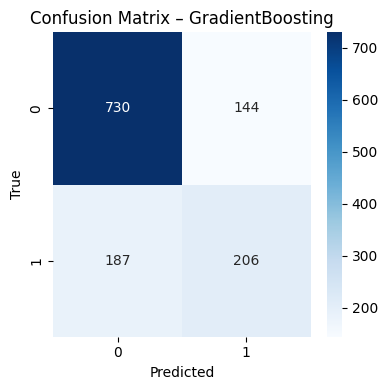

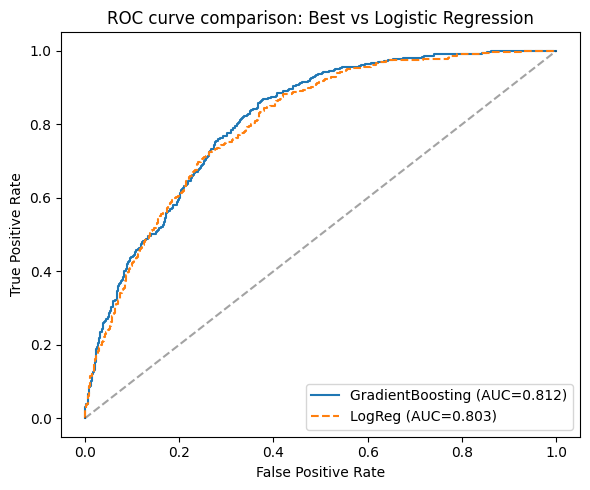

In [102]:
# ----------------------------------
# 1. Best model 선정
# ----------------------------------
best_name = cv_df.iloc[0]["model"]
print(f">>> Best model by CV AUC: {best_name}")

best_clf = models[best_name]

best_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", best_clf)
])

# train 데이터 전체로 다시 학습
best_pipe.fit(X_train, y_train)

# test set 예측
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("\n=== Test set performance (Best model) ===")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix – {best_name}")
plt.tight_layout()
plt.show()

# ROC curve 비교 (Best vs LogReg)
logreg_pipe = Pipeline([
    ("preprocess", preprocessor),
    ("clf", models["LogReg"])
])
logreg_pipe.fit(X_train, y_train)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]

fpr_best, tpr_best, _ = roc_curve(y_test, y_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(6,5))
plt.plot(fpr_best, tpr_best, label=f"{best_name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_score(y_test, y_proba_lr):.3f})", linestyle="--")
plt.plot([0,1], [0,1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve comparison: Best vs Logistic Regression")
plt.legend()
plt.tight_layout()
plt.show()



=== Top 15 feature importances (GradientBoosting) ===
                       feature  importance
2                          asa    0.308747
0                          age    0.263842
1                          bmi    0.111945
5                     preop_pt    0.058898
4                    preop_plt    0.046816
8                      preop_k    0.039701
9                   preop_gluc    0.034101
3                     preop_hb    0.031298
6                   preop_aptt    0.024238
7                     preop_na    0.018002
25      optype_Transplantation    0.011703
12  department_General surgery    0.008031
29                  preop_dm_0    0.007365
10                       sex_F    0.006096
30                  preop_dm_1    0.005400


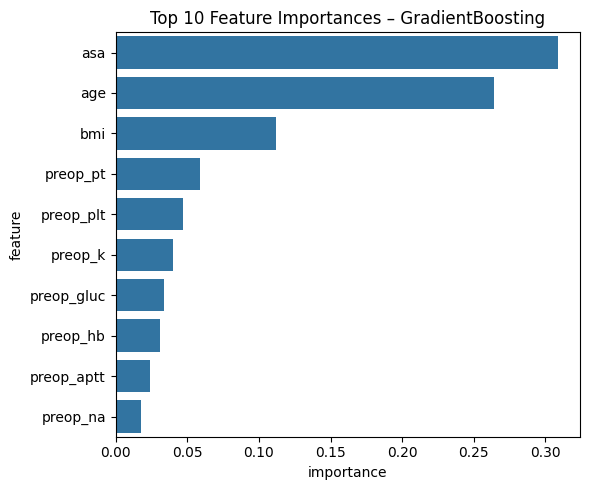

In [103]:
# ----------------------------------
# 2. Feature importance (GradientBoosting 전용)
# ----------------------------------

gb_model = best_pipe.named_steps["clf"]
ct = best_pipe.named_steps["preprocess"]

# OneHotEncoder에서 최종 피처 이름 뽑기
ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

importances = gb_model.feature_importances_
fi = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\n=== Top 15 feature importances (GradientBoosting) ===")
print(fi.head(15))

plt.figure(figsize=(6,5))
sns.barplot(data=fi.head(10), x="importance", y="feature", orient="h")
plt.title("Top 10 Feature Importances – GradientBoosting")
plt.tight_layout()
plt.show()


In [104]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [shap]2/3 [shap]pickle]


In [105]:
import numpy as np

# Pipeline에서 OneHotEncoder 가져오기
ct = best_pipe.named_steps["preprocess"]

ohe = ct.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])
len(all_feature_names)


31

In [106]:
import shap

# tree explainer
explainer = shap.TreeExplainer(best_clf)


In [107]:
best_clf = best_pipe.named_steps["clf"]

In [108]:
# transform test set through preprocessor
X_test_transformed = ct.transform(X_test)

# SHAP values 계산
shap_values = explainer.shap_values(X_test_transformed)


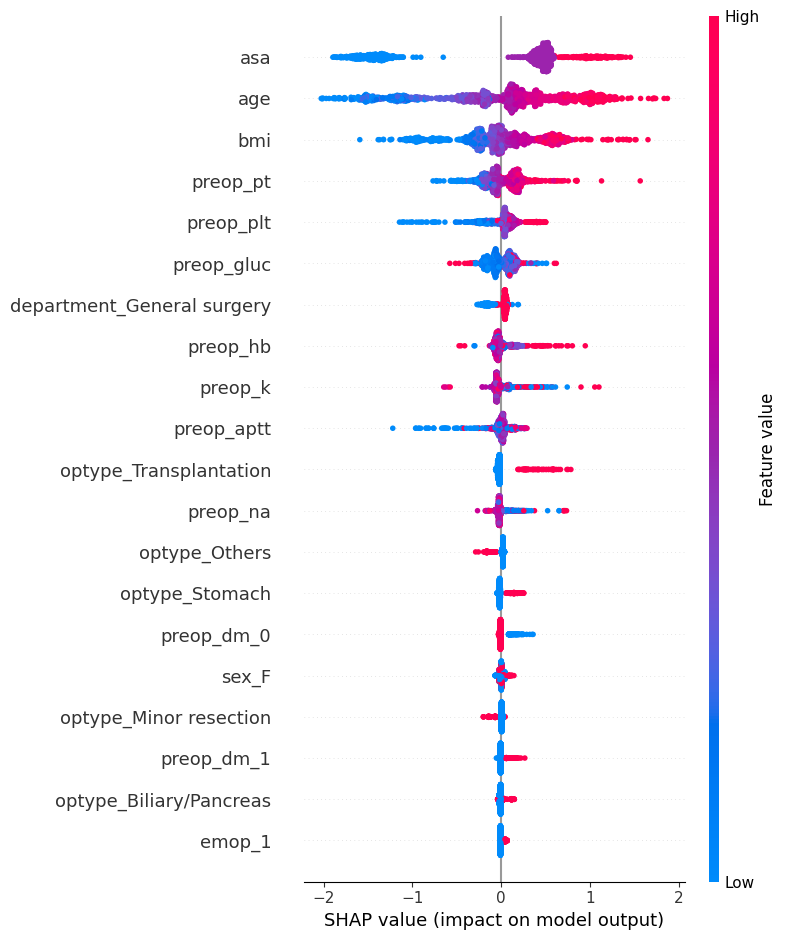

In [109]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=all_feature_names,
    plot_type="dot"
)

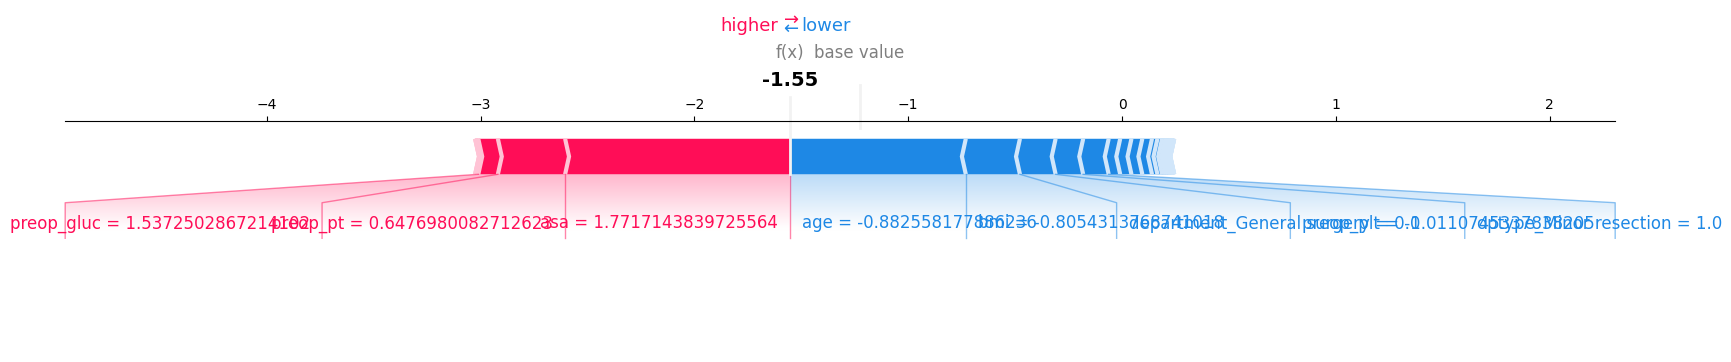

In [110]:
# test sample 활용 설명 
i = 10  # 10번째 test sample
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_test_transformed[i, :],
    feature_names=all_feature_names,
    matplotlib=True
)


총 feature 수: 31
SHAP values shape: (1267, 31)


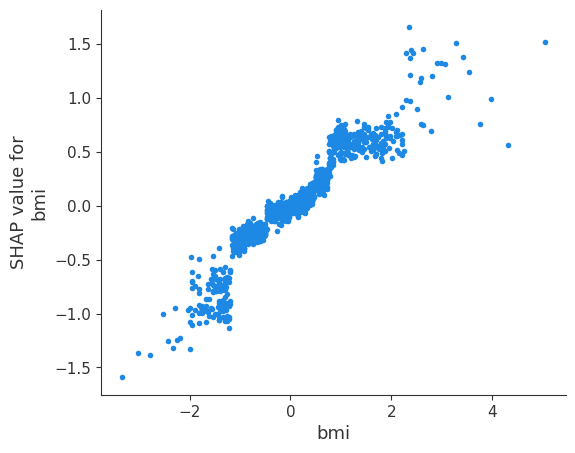

In [111]:
# ============================================
# 0) 필요 모듈
# ============================================
import shap
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 1) Pipeline 구성 요소 가져오기
# ============================================
preprocessor = best_pipe.named_steps["preprocess"]
best_clf = best_pipe.named_steps["clf"]     # GradientBoostingClassifier

# ============================================
# 2) Feature 이름 구성
# ============================================
# OHE categorical 이름
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# numeric + categorical 전체 이름
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

print("총 feature 수:", len(all_feature_names))

# ============================================
# 3) Test 데이터를 preprocessor로 변환
# ============================================
X_test_transformed = preprocessor.transform(X_test)

# ============================================
# 4) SHAP Explainer 생성
# ============================================
explainer = shap.TreeExplainer(best_clf)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test_transformed)

print("SHAP values shape:", shap_values.shape)

# ============================================
# 5) Dependence Plot (BMI 기준)
# ============================================
shap.dependence_plot(
    "bmi",
    shap_values,
    X_test_transformed,
    feature_names=all_feature_names,
    interaction_index=None  # 기본 설정 (가장 관련 있는 feature 자동 선택)
)


In [112]:
# SHAP Dependence Plot – Top 10 Features 자동 생성 코드
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1) Preprocessor + Model 불러오기
preprocessor = best_pipe.named_steps["preprocess"]
best_clf = best_pipe.named_steps["clf"]

# 2) 전체 feature 이름 구성
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, cat_feature_names])

print("전체 Feature 수 =", len(all_feature_names))

# 3) Test 데이터 변환
X_test_transformed = preprocessor.transform(X_test)

# 4) SHAP explainer 생성
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test_transformed)

# 5) Feature importance (mean |SHAP|) 계산 → Top 10 선정
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[::-1][:10]
top_features = [all_feature_names[i] for i in top_idx]

print("Top 10 SHAP 중요 Feature:")
for f in top_features:
    print("  -", f)

# 6) Dependence Plot 자동 생성
import os

os.makedirs("shap_dependence_plots", exist_ok=True)

for feature_name in top_features:
    print(f"\n📌 Plotting dependence for: {feature_name}")

    plt.figure(figsize=(6,4))
    shap.dependence_plot(
        feature_name,
        shap_values,
        X_test_transformed,
        feature_names=all_feature_names,
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feature_name}")
    plt.tight_layout()
    plt.savefig(f"shap_dependence_plots/{feature_name}_dependence.png", dpi=150)
    plt.close()

print("\n✨ 모든 SHAP dependence plot 저장됨 → shap_dependence_plots/ 폴더")


전체 Feature 수 = 31
Top 10 SHAP 중요 Feature:
  - asa
  - age
  - bmi
  - preop_pt
  - preop_plt
  - preop_gluc
  - department_General surgery
  - preop_hb
  - preop_k
  - preop_aptt

📌 Plotting dependence for: asa

📌 Plotting dependence for: age

📌 Plotting dependence for: bmi

📌 Plotting dependence for: preop_pt

📌 Plotting dependence for: preop_plt

📌 Plotting dependence for: preop_gluc

📌 Plotting dependence for: department_General surgery

📌 Plotting dependence for: preop_hb

📌 Plotting dependence for: preop_k

📌 Plotting dependence for: preop_aptt

✨ 모든 SHAP dependence plot 저장됨 → shap_dependence_plots/ 폴더


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>


=== SHAP dependence: asa ===


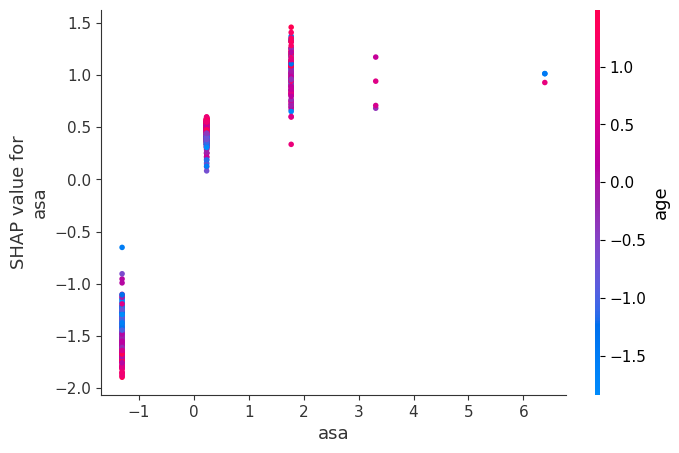


=== SHAP dependence: age ===


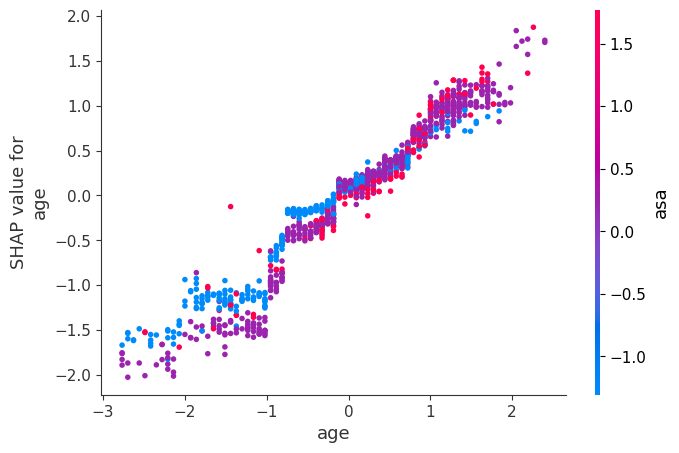


=== SHAP dependence: bmi ===


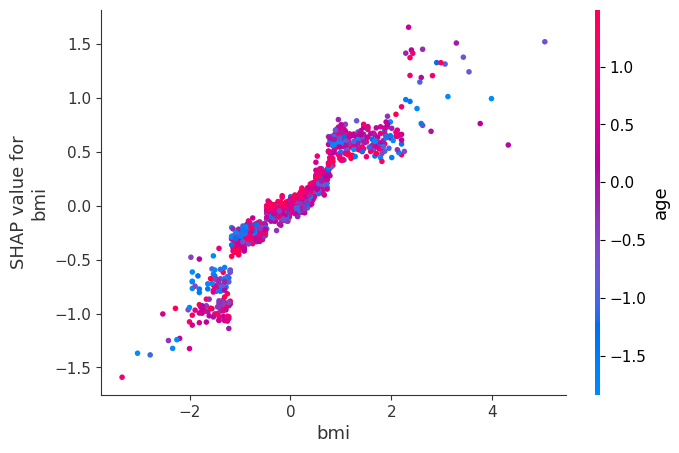


=== SHAP dependence: preop_pt ===


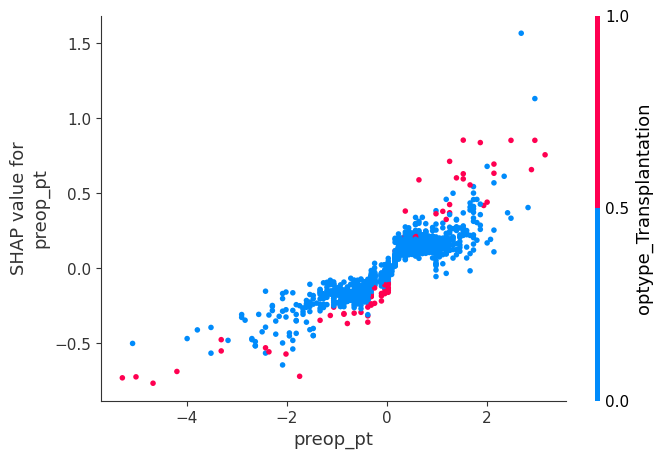


=== SHAP dependence: preop_plt ===


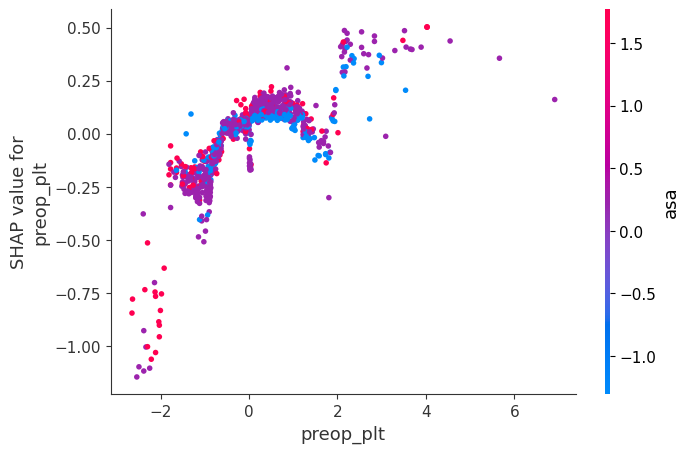


=== SHAP dependence: preop_gluc ===


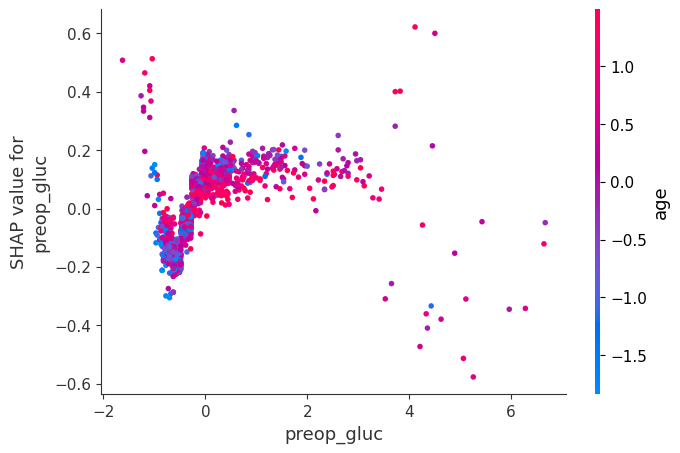


=== SHAP dependence: department_General surgery ===


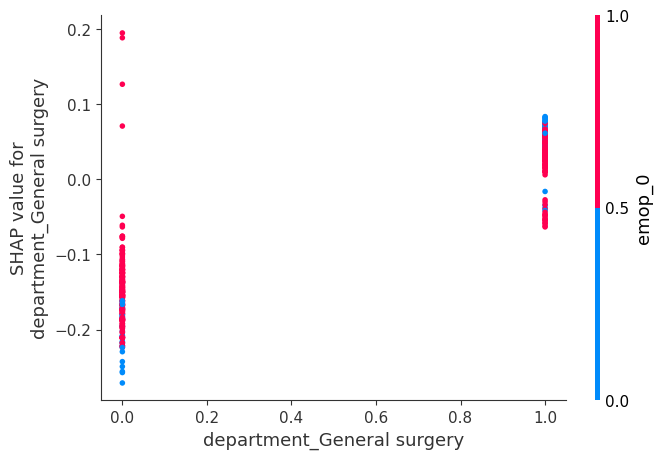


=== SHAP dependence: preop_hb ===


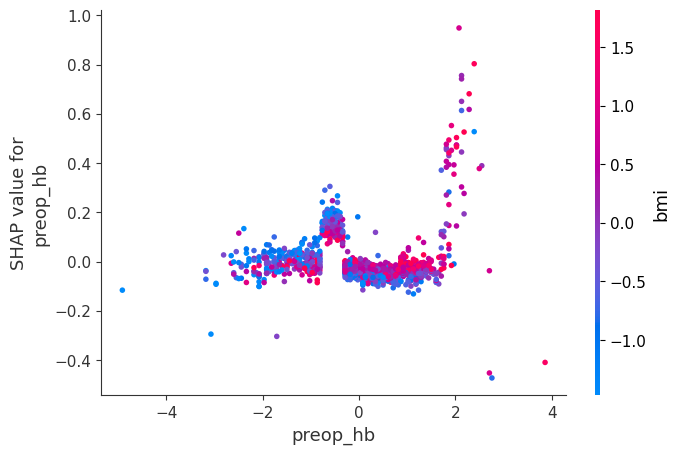


=== SHAP dependence: preop_k ===


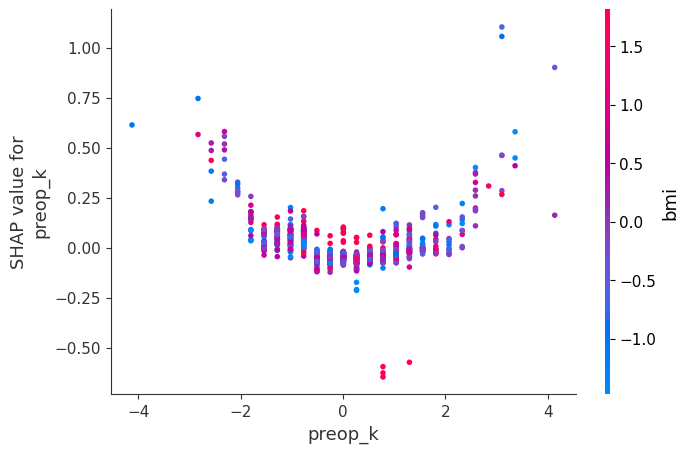


=== SHAP dependence: preop_aptt ===


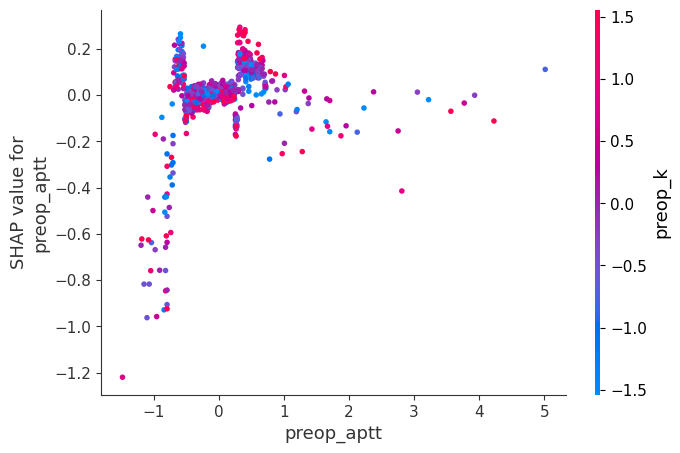

In [113]:
import shap

preprocessor = best_pipe.named_steps["preprocess"]
best_clf = best_pipe.named_steps["clf"]

ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

X_test_transformed = preprocessor.transform(X_test)

explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test_transformed)

shap.initjs()

important_features = [
    "asa",
    "age",
    "bmi",
    "preop_pt",
    "preop_plt",
    "preop_gluc",
    "department_General surgery",
    "preop_hb",
    "preop_k",
    "preop_aptt",
]

for f in important_features:
    print(f"\n=== SHAP dependence: {f} ===")
    shap.dependence_plot(
        f,
        shap_values,
        X_test_transformed,
        feature_names=all_feature_names,
    )


# Clustering

## 1) Gower Distance 계산 코드

In [118]:
import gower
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 1) 클러스터링 컬럼만 추출
cluster_features = [
    "age", "bmi", "asa",
    "preop_hb", "preop_plt", "preop_pt", "preop_aptt",
    "preop_gluc",
    "sex", "department", "optype", 
    "preop_dm", "emop"
]

df_cluster = df[cluster_features].copy()

# 2) Numeric / Categorical 분리
num_cols = df_cluster.select_dtypes(include=['float64','int64']).columns
cat_cols = df_cluster.select_dtypes(include=['object','category']).columns

# 3) NA 처리
# numeric → median
df_cluster[num_cols] = df_cluster[num_cols].fillna(df_cluster[num_cols].median())

# categorical → most common
df_cluster[cat_cols] = df_cluster[cat_cols].fillna(df_cluster[cat_cols].mode().iloc[0])

print("💡 결측 처리 완료")
print(df_cluster.isna().sum())

💡 결측 처리 완료
age           0
bmi           0
asa           0
preop_hb      0
preop_plt     0
preop_pt      0
preop_aptt    0
preop_gluc    0
sex           0
department    0
optype        0
preop_dm      0
emop          0
dtype: int64


In [120]:
import gower
gower_dist = gower.gower_matrix(df_cluster)

print("Gower distance shape:", gower_dist.shape)
print("NaN in gower_dist?", np.isnan(gower_dist).sum())

Gower distance shape: (6331, 6331)
NaN in gower_dist? 0


## 2) 최적 클러스터 수(k) 탐색

In [121]:
range_k = [2,3,4,5,6]
scores = {}

for k in range_k:
    model = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',
        linkage='average'
    )
    labels = model.fit_predict(gower_dist)

    sil = silhouette_score(gower_dist, labels, metric="precomputed")
    scores[k] = sil
    print(f"k={k}, Silhouette={sil:.4f}")

best_k = max(scores, key=scores.get)
print("\n🚀 Best k =", best_k)


k=2, Silhouette=0.4676
k=3, Silhouette=0.2758
k=4, Silhouette=0.2967
k=5, Silhouette=0.2879
k=6, Silhouette=0.2848

🚀 Best k = 2


## 3) 최종 클러스터링 실행

In [ ]:
best_model = AgglomerativeClustering(
    n_clusters=best_k,
    metric='precomputed',
    linkage='average'
)

cluster_labels = best_model.fit_predict(gower_dist)
df_cluster["cluster"] = cluster_labels


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

## 4) 클러스터별 HTN 비율·ASA·나이·BMI 비교

In [ ]:
df_cluster["preop_htn"] = df["preop_htn"].values

# HTN 비율
print(df_cluster.groupby("cluster")["preop_htn"].mean())

# numeric summary
print(df_cluster.groupby("cluster")[["age","bmi","asa","preop_gluc","preop_pt"]].mean())


## 5) 시각화: Radar plot or profile plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_vars = ["age","bmi","asa","preop_gluc","preop_pt"]

cluster_centers = df_cluster.groupby("cluster")[num_vars].mean()

for c in cluster_centers.index:
    vals = cluster_centers.loc[c].values
    angles = np.linspace(0, 2*np.pi, len(vals), endpoint=False)
    vals = np.concatenate((vals, [vals[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    plt.figure(figsize=(6,6))
    plt.polar(angles, vals)
    plt.title(f"Cluster {c} Profile")
    plt.show()
